In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn import datasets

SEED=200
plt.ion()

# Implementar uma das duas funções abaixo:
## Reescalar entre 0 e 1 ou Normalização z-score

In [2]:
def rescale(df, columns, maximum=None, minimum=None):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser reescaladas
    maximum: dicionário com os valores maximos, com cada chave representando uma coluna
    minimum: dicionário com os valores minimos, com cada chave representando uma coluna
    retorna o dataset reescalado
    """
    from copy import copy
    rescaledDF = copy(df)
    nmax,nmin = {},{}
    
    for c in columns:
        minc,maxc = min(df[c]),max(df[c])
        
        try:
            nmax[c]=maximum[c]
        except:
            nmax[c]=maxc
            
        try:
            nmin[c]=minimum[c]
        except:
            nmin[c]=minc
        
        rescaled = (df[c] - minc) * (nmax[c]-nmin[c]) / (maxc - minc) + nmin[c]
        rescaledDF[c] = rescaled
        
    return rescaledDF,nmax,nmin

def normalize(df, columns, mean=None, std=None):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser normalizadas
    mean: dicionário com os valores médios, com cada chave representando uma coluna
    std: dicionário com os desvios padrão, com cada chave representando uma coluna
    retorna o dataset normalizado
    """
    raise NotImplementedError("implementar a função normalize")
    

# A célula seguinte carrega o dataset. Não é necessário modificar.

In [3]:
"""Load dataset"""
iris = datasets.load_iris()

df_full = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                       columns= iris['feature_names'] + ['target'])

def get_train_test_inds(y, train_proportion=0.7):
    """
    y: coluna do atributo alvo
    retorna os indices de treino e teste estratificados pela classe
    """
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds


train_inds, test_inds = get_train_test_inds(df_full.loc[:, "target"])
df_full[['target']] = df_full[['target']].astype(int)
df = df_full[train_inds]
df_val = df_full[test_inds]

In [4]:
"""Use este trecho no caso de optar por reescalar"""
df, maximum, minimum = rescale(df, df.columns[0:4])
df_val, _, _ = rescale(df_val, df_val.columns[0:4], maximum, minimum)

# """Use este trecho no caso de optar por normalizar"""
# df, mean, std = normalize(df, df.columns[0:4])
# df_val, _, _ = normalize(df_val, df_val.columns[0:4], mean, std)

# Funções de Ativação e Softmax
## Implementar Relu, Sigmoid e Softmax

In [5]:
class Relu(object):
    def forward(self, x):
        """
        x: Entrada (batch_size, numero_de_neuronios)
        retorna a saída da ativação relu (batch_size, numero de neuronios)
        """
        r = []
        for xs in x:
            r.append(np.asarray(
                    [v if v > 0 else 0 for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o relu")
    
    def backward(self, x):
        """
        x: Entrada no backward (batch_size, numero_de_neuronios)
        retorna a saída da derivada da ativação relu (batch_size, numero_de_neuronios)
        """
        r = []
        for xs in x:
            r.append(np.asarray(
                    [1 if v > 0 else 0 for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o relu")

        
class Sigmoid(object):
    def sig(self,v):
        from math import e
        return 1/(1 + e**-v)
    
    def forward(self, x):
        """
        x: Entrada (batch_size, numero_de_neuronios)
        retorna a saída da ativação sigmoidal (batch_size, numero_de_neuronios)
        """
        r = []
        for xs in x:
            r.append(np.asarray(
                    [self.sig(v) for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o sigmoid")
        
    def backward(self, x):
        """
        x: Entrada no backward (batch_size, numero_de_neuronios)
        retorna a saída da derivada da ativação sigmoidal (batch_size, numero_de_neuronios)
        """
        
        r = []
        for xs in x:
            r.append(np.asarray(
                    [(1-self.sig(v))*self.sig(v) if v > 0 else 0 for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o sigmoid")
        

def softmax(x):
    """
    x: Entrada (batch_size, numero_de_neuronios)
    retorna a probabilidade de cada classe (batch_size, numero_de_neuronios)
    """
    from math import e
    
    r = []
    for xs in x:
        e_z = [e**v for v in xs]
#         for i,v in enumerate(xs):
#             print (v, e**v, e_z[i])
        s = sum(e_z)
        r.append(np.asarray([v/s for v in e_z]))
    
    return np.asarray(r)
#     raise NotImplementedError("implementar o softmax")
    
def back_softmax(x,y):
    d_ij = lambda i, j : xs[i] * ((i==j) - xs[j])
    y = np.asarray(y)
    r = []
    for j,xs in enumerate(x):
#         for i in range(len(xs)):
#             e = [d_ij(i,j) for j in range(x.shape[1])]
#             r.append(np.asarray([e]))
        e = [d_ij(i,y[i]) for i in range(x.shape[1])]
        r.append(np.asarray(e))
    
    return np.asarray(r)
    


In [40]:
def t_backward(self,y):
        def cat_ce(ys,preds):
            from math import log
            def ce(yi,pred):
#                 print(yi,pred)
                if yi:
                    return -log(pred + 1e-15)
                return -log(1-pred + 1e-15)
            
            ac = sum([sum(map(lambda vi : 
                               ce(vi[0],vi[1]), zip(ys[i],preds[i])
                                ))
                          for i in range(len(ys))])
            return ac/len(ys)
            
        y_adj = []
        for i in y:
            a = np.zeros(self.output_size)
            
            if self.output_size == 1:
                a[0] = i
            else:
                a[i] = 1
            
            y_adj.append(a)
        
        loss = cat_ce(y_adj,self.intermediate_results[-1])
        print (loss)
        
        last = self.intermediate_results[-1] - np.asarray(y_adj)
        
#         f = [self.activation_fn.backward,self.activation_fn.backward, back_softmax]
        f = [Relu().backward, lambda x : 1]
        
        adds = {}
        
        for i in range(self.LAYERS,0,-1):
            tmp = []
            current = f[i-1](np.asarray(self.intermediate_results[i]))
            last = last * current
            
            for col in range(self.grads["b"+str(i)].shape[0]):
                lT = last.transpose()
                lT = np.asarray(list(map(lambda x : x.mean(),lT)))
                assert self.grads["b"+str(i)].shape == lT.shape
                self.grads["b"+str(i)] = lT
            
            w = self.params["w"+str(i)]
            
            for xs, l in zip(self.intermediate_results[i-1],last): # for each batch
                tmp.append([])
                for wi in range(w.shape[0]):
                    p = []
                    for j,xsj in enumerate(xs):
                        v = l[wi]
                        try:
                            adds["%s|%s|%s" % (str(i),str(wi),str(j))] += xsj * v,1
                        except:
                            adds["%s|%s|%s" % (str(i),str(wi),str(j))] = np.asarray([xsj * v,1])
                        
                        p.append(w[wi,j] * v)
                    tmp[-1] = np.asarray(p[:])
                    
                        
                tmp[-1] = np.asarray(tmp[-1])
            last = np.asarray(tmp[:])
        
        for k,v in adds.items():
            i,wi,j = list(map(int,k.split('|')))
            self.grads["w"+str(i)][wi,j] = v[0]/v[1]
        
        return loss,self.grads
#         raise NotImplementedError("implementar o backward")

In [43]:
class NeuralTest(object):
    def __init__(self, input_size=2, hidden_size1=2, hidden_size2=None, output_size=1,
                 activation_fn='relu', learning_rate=1e-2, sigma=1., weight_decay=0.1):
        """Inicializacao pronta. Nao alterar"""
        self.input_size = input_size # 2
        self.output_size = output_size # 1
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.sigma = sigma
        
        # inicializa as matriz dos parametros
        self.params = {}
        self.params["w1"] = np.asarray([[3,1],[-0.5,2]])
        self.params["b1"] = np.asarray([-0.5,1.2])
        self.params["w2"] = np.asarray([[-1.5,0.4]])
        self.params["b2"] = np.asarray([0.8])
        
        # inicializa as matrizes de gradientes
        self.grads = {}
        self.grads["w1"] = np.zeros((input_size, hidden_size1))
        self.grads["b1"] = np.zeros(hidden_size1)
        self.grads["w2"] = np.zeros((hidden_size1, output_size)).transpose()
        self.grads["b2"] = np.zeros(output_size)
        
        for i in range(2):
            i += 1
            kw,kb = "w"+str(i),"b"+str(i)
            assert self.params[kw].shape == self.grads[kw].shape
            assert self.params[kb].shape == self.grads[kb].shape
        
    def forward(self, x=np.asarray([-1,2])):
        """
        x: entrada da rede neural
        retorna as probabilidades de cada classe (batch_size, numero_de_classes)
        """
        self.LAYERS = 2
        
        if len(x.shape) == 1:
            x = np.asarray([x])
        
        self.intermediate_results = [x]
        f = [Relu().forward,Sigmoid().forward]
        
        for i in range(self.LAYERS):
            tmp = []
            w = self.params["w"+str(i+1)]
            b = self.params["b"+str(i+1)]
            for xs in self.intermediate_results[-1]:
                p = []
                for wi in range(w.shape[0]):
                    p.append(0)
                    for wj in range(w.shape[1]):
                        p[-1] += w[wi,wj] * xs[wj]
                    p[-1] += b[wi]
                tmp.append(p)
            self.intermediate_results.append(f[i](tmp))
        
        return self.intermediate_results[-1]
        
    def backward(self, y):
        """
        y: indices das classes esperadas (batch_size, 1)
        retorna o loss e o dicionario de gradientes
        """
        return t_backward(self,y)
            

n = NeuralTest()
n.intermediate_results[-1] = n.forward()
n.backward(np.asarray([0]))

3.1249344133057266


(3.1249344133057266,
 {'b1': array([0.        , 0.38242407]),
  'b2': array([0.95606018]),
  'w1': array([[ 0.        , -0.        ],
         [-0.38242407,  0.76484815]]),
  'w2': array([[0.        , 5.44954305]])})

# A célula seguinte implementa uma Rede Neural com 2 camadas escondidas. 

In [12]:
class NeuralNetwork(object):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size,
                 activation_fn='relu', learning_rate=1e-2, sigma=1., weight_decay=0.1):
        """Inicializacao pronta. Nao alterar"""
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.sigma = sigma
        
        # relu or sigmoid
        if activation_fn == 'relu':
            self.activation_fn = Relu()
        elif activation_fn == 'sigmoid':
            self.activation_fn = Sigmoid()
        
        # inicializa as matriz dos parametros
        self.params = {}
        self.params["w1"] = sigma * np.random.randn(input_size, hidden_size1)
        self.params["b1"] = np.zeros(hidden_size1)
        self.params["w2"] = sigma * np.random.randn(hidden_size1, hidden_size2)
        self.params["b2"] = np.zeros(hidden_size2)
        self.params["w3"] = sigma * np.random.randn(hidden_size2, output_size)
        self.params["b3"] = np.zeros(output_size)
        
        # inicializa as matrizes de gradientes
        self.grads = {}
        self.grads["w1"] = np.zeros((input_size, hidden_size1))
        self.grads["b1"] = np.zeros(hidden_size1)
        self.grads["w2"] = np.zeros((hidden_size1, hidden_size2))
        self.grads["b2"] = np.zeros(hidden_size2)
        self.grads["w3"] = np.zeros((hidden_size2, output_size))
        self.grads["b3"] = np.zeros(output_size)
        
    def forward(self, x):
        """
        x: entrada da rede neural
        retorna as probabilidades de cada classe (batch_size, numero_de_classes)
        """
        self.LAYERS = 3
        
        if len(x.shape) == 1:
            x = np.asarray([x])
        
        self.intermediate_results = [x]
        f = [self.activation_fn.forward,self.activation_fn.forward,softmax]
        
        for i in range(self.LAYERS):
            tmp = []
            w = self.params["w"+str(i+1)]
            b = self.params["b"+str(i+1)]
            for xs in self.intermediate_results[-1]:
                p = []
                for wj in range(w.shape[1]):
                    p.append(0)
#                     print (len(xs),w.shape,len(b))
                    for wi in range(w.shape[0]):
                        p[-1] += w[wi,wj] * xs[wi]
                    p[-1] += b[wj]
                tmp.append(p)
            self.intermediate_results.append(f[i](tmp))
        
        return self.intermediate_results[-1]
#         raise NotImplementedError("implementar o forward")
        
    def backward(self, y):
        """
        y: indices das classes esperadas (batch_size, 1)
        retorna o loss e o dicionario de gradientes
        """
        def cat_ce(ys,preds):
            from math import log
            def ce(yi,pred):
#                 print(yi,pred)
                if yi:
                    return -log(pred + 1e-15)
                return -log(1-pred + 1e-15)
            
            ac = sum([sum(map(lambda vi : 
                               ce(vi[0],vi[1]), zip(ys[i],preds[i])
                                ))
                          for i in range(len(ys))])
            return ac/len(ys)
            
        y_adj = []
        for i in y:
            a = np.zeros(self.output_size)
            
            if self.output_size == 1:
                a[0] = i
            else:
                a[i] = 1
            
            y_adj.append(a)
        
        loss = cat_ce(y_adj,self.intermediate_results[-1])
#         print (loss)
        
        last = np.asarray(y_adj)
        
        f = [self.activation_fn.backward,self.activation_fn.backward, lambda x : back_softmax(x,y)]
#         f = [self.activation_fn.backward,self.activation_fn.backward, lambda x : 1]
        
        adds = {}
        
        for i in range(self.LAYERS,0,-1):
            tmp = []
            current = f[i-1](np.asarray(self.intermediate_results[i]))
            last = last * current
            
            for col in range(self.grads["b"+str(i)].shape[0]):
                lT = last.transpose()
                lT = np.asarray(list(map(lambda x : x.mean(),lT)))
                assert self.grads["b"+str(i)].shape == lT.shape
                self.grads["b"+str(i)] = lT
            
            w = self.params["w"+str(i)]
            
            for xs, l in zip(self.intermediate_results[i-1],last): # for each batch
                tmp.append([])
                for wi in range(w.shape[0]):
                    p = []
                    xsi = xs[wi]
                    for j,v in enumerate(l):
#                         v = l[wi]
                        try:
                            adds["%s|%s|%s" % (str(i),str(wi),str(j))] += xsi * v,1
#                             adds["%s|%s|%s" % (str(i),str(wi),str(j))] += xsj * v,1
                        except:
                            adds["%s|%s|%s" % (str(i),str(wi),str(j))] = np.asarray([xsi * v,1])
#                             adds["%s|%s|%s" % (str(i),str(wi),str(j))] = np.asarray([xsj * v,1])
                        
                        p.append(w[wi,j] * v)
#                     tmp[-1] = np.asarray(p[:])
                    tmp[-1].append(np.asarray(sum(p)))
                    
                        
                tmp[-1] = np.asarray(tmp[-1])
            last = np.asarray(tmp[:])
        
        for k,v in adds.items():
            i,wi,j = list(map(int,k.split('|')))
            self.grads["w"+str(i)][wi,j] = self.sigma + self.weight_decay*v[0]/v[1]
        
        return loss,self.grads
#         raise NotImplementedError("implementar o backward")
        
    def optimize(self):
        """
        Faz um step do gradiente descendente, nao alterar
        """
        self.params["w3"] = self.params["w3"] - self.learning_rate*(self.grads['w3'])
        self.params["b3"] = self.params["b3"] - self.learning_rate*(self.grads['b3'])

        self.params["w2"] = self.params["w2"] - self.learning_rate*(self.grads['w2'])
        self.params["b2"] = self.params["b2"] - self.learning_rate*(self.grads['b2'])
        
        self.params["w1"] = self.params["w1"] - self.learning_rate*(self.grads['w1'])
        self.params["b1"] = self.params["b1"] - self.learning_rate*(self.grads['b1'])

# Devem ser alterados os hiperparâmetros para melhor otimização da rede
## Alguns dos hiperparâmetros que podem ser modificados estão na célula abaixo

In [9]:
learning_rate = 1e-3
activation_fn = 'relu'
weight_decay = 0.001 # lambda
epochs = 1000
batch_size = 10

In [10]:
classes = df.loc[:,"target"].unique() # numero de classes do dataset
classes.sort()

network = NeuralNetwork(df.shape[1]-1, 10, 10, output_size=len(classes), learning_rate=learning_rate,
                        activation_fn=activation_fn, weight_decay=weight_decay)

<IPython.core.display.Javascript object>


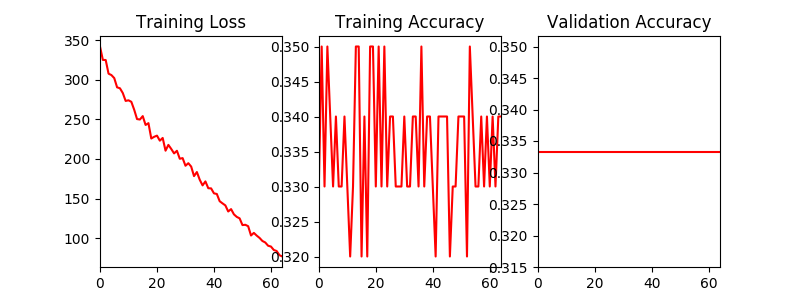

[-2.65465405e-29  1.00000000e+01]
[-1.50784202e-33  1.00000000e+01]
[-1.1292255e-08  1.0000000e+01]
[-1.69607684e-30  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.19295212e-29  1.00000000e+01]
[-1.09576944e-33  1.00000000e+01]
[-8.20234002e-09  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.41693446e-29  1.00000000e+01]
[-1.20697445e-33  1.00000000e+01]
[-9.11568404e-09  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.71256911e-29  1.00000000e+01]
[-1.09548909e-33  1.00000000e+01]
[-7.68818658e-09  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[6.25907728e-31 1.00000000e+01]
[-4.14931871e-31  1.00000000e+01]
[ 0. 10.]
[1.17734805e-30 1.00000000e+01]
[ 0. 10.]
[2.80150139e-33 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.231352

[-7.13332477e-06  1.00000000e+01]
[2.36775509e-06 1.00000000e+01]
[ 0. 10.]
[-4.5517614e-06  1.0000000e+01]
[-7.56520055e-28  1.00000000e+01]
[-4.04427306e-33  1.00000000e+01]
[2.59114309e-08 1.00000000e+01]
[-4.4528094e-29  1.0000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-6.21050256e-28  1.00000000e+01]
[-3.21426417e-33  1.00000000e+01]
[1.85183472e-08 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-6.78106317e-28  1.00000000e+01]
[-3.35507629e-33  1.00000000e+01]
[2.07424122e-08 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-7.7744801e-28  1.0000000e+01]
[-3.09981322e-33  1.00000000e+01]
[1.74871005e-08 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.65872168e-29 1.00000000e+01]
[-1.07159061e-29  1.00000000e+01]
[ 0. 10.]
[3.10525031e-29 

[ 0. 10.]
[ 0. 10.]
[-8.53410749e-10  1.00000000e+01]
[3.67144436e-09 1.00000000e+01]
[-6.84128114e-27  1.00000000e+01]
[-0. 10.]
[-8.90165554e-12  1.00000000e+01]
[ 0. 10.]
[-6.82401503e-10  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.25866326e-09  1.00000000e+01]
[7.13772677e-09 1.00000000e+01]
[-6.27917636e-27  1.00000000e+01]
[-0. 10.]
[-1.73058826e-11  1.00000000e+01]
[ 0. 10.]
[-1.32667011e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.39111142e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[4.11553961e-27 1.00000000e+01]
[-2.60755221e-27  1.00000000e+01]
[-0. 10.]
[7.6774564e-27 1.0000000e+01]
[ 0. 10.]
[9.07115797e-29 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.43403491e-26  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.39739204e-26 1.00000000e+01]
[4.49352006e-09 1.00000000e+01]
[2.30545868e-26 1.00000000e+01]
[5.26161417e-09 1.00000000e+01]
[-1.13476556e-08  1.00000000e+01]
[9.25508199e-09 

/home/murilo/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


[1.24667276e-04 1.00000000e+01]
[3.5678172e-29 1.0000000e+01]
[-1.01604271e-08  1.00000000e+01]
[9.13250614e-06 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.09300944e-04 1.00000000e+01]
[2.74287312e-29 1.00000000e+01]
[-7.38691739e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.17594873e-04 1.00000000e+01]
[2.9710848e-29 1.0000000e+01]
[-8.1870674e-09  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.3336022e-04 1.0000000e+01]
[2.77171334e-29 1.00000000e+01]
[-6.84244776e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.46116279e-06  1.00000000e+01]
[2.7718396e-06 1.0000000e+01]
[ 0. 10.]
[-8.29323178e-06  1.00000000e+01]
[ 0. 10.]
[-1.31073088e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.53945062e-05 1.00000000e+01]


[-5.38425602e-25  1.00000000e+01]
[2.63192853e-32 1.00000000e+01]
[-2.20591444e-44  1.00000000e+01]
[-1.97037285e-26  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-4.43480502e-25  1.00000000e+01]
[2.08027828e-32 1.00000000e+01]
[-1.54360743e-44  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-4.66799614e-25  1.00000000e+01]
[2.18211615e-32 1.00000000e+01]
[-1.75484433e-44  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-5.42191655e-25  1.00000000e+01]
[2.06808157e-32 1.00000000e+01]
[-1.4192155e-44  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.08008e-26 1.00000e+01]
[-6.53732641e-27  1.00000000e+01]
[-0. 10.]
[1.99865977e-26 1.00000000e+01]
[ 0. 10.]
[4.21204018e-28 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.67949397e-26  1.0000

[ 0. 10.]
[-4.83131073e-06  1.00000000e+01]
[ 0. 10.]
[-1.20732347e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[8.83945343e-06 1.00000000e+01]
[-3.00975631e-05  1.00000000e+01]
[1.78605818e-05 1.00000000e+01]
[ 0. 10.]
[-5.55059496e-05  1.00000000e+01]
[ 0. 10.]
[-1.38706946e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.01554689e-04 1.00000000e+01]
[-2.91682408e-06  1.00000000e+01]
[1.73091007e-06 1.00000000e+01]
[ 0. 10.]
[-5.37920926e-06  1.00000000e+01]
[ 0. 10.]
[-1.34424092e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[9.84189847e-06 1.00000000e+01]
[1.0603502e-37 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.08918839e-38  1.00000000e+01]
[ 0. 10.]
[6.8494986e-38 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.65046586e-38 1.00000000e+01]
[-1.18422077e-05  1.00000000e+01]
[7.02743669e-06 1.00000000e+01]
[ 0. 10.]
[-2.18394088e-05  1.00000000e+01]
[ 0. 10.]
[-5.45757294e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.9957777e-05 1.0000000e+01]
[-1.10266289e-05  

[-2.18118213e-05  1.00000000e+01]
[1.13183804e-31 1.00000000e+01]
[-1.13175107e-08  1.00000000e+01]
[-6.64721278e-07  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.82040202e-05  1.00000000e+01]
[8.79744108e-32 1.00000000e+01]
[-8.1506664e-09  1.0000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.9105822e-05  1.0000000e+01]
[9.33034802e-32 1.00000000e+01]
[-9.09922747e-09  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-2.21169145e-05  1.00000000e+01]
[8.22343582e-32 1.00000000e+01]
[-7.54347536e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[5.03113415e-07 1.00000000e+01]
[-2.92689212e-07  1.00000000e+01]
[-0. 10.]
[9.24732323e-07 1.00000000e+01]
[ 0. 10.]
[2.67003611e-08 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.68148334e-06  1.

[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[6.26153901e-05 1.00000000e+01]
[-1.5965995e-34  1.0000000e+01]
[-3.10219683e-44  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.17329659e-06  1.00000000e+01]
[6.64629372e-07 1.00000000e+01]
[ 0. 10.]
[-2.14703595e-06  1.00000000e+01]
[ 0. 10.]
[-7.30087934e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.87208396e-06 1.00000000e+01]
[-1.62659741e-05  1.00000000e+01]
[9.21407612e-06 1.00000000e+01]
[ 0. 10.]
[-2.97653904e-05  1.00000000e+01]
[ 0. 10.]
[-1.01215596e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[5.36805592e-05 1.00000000e+01]
[-1.54443438e-06  1.00000000e+01]
[8.74865277e-07 1.00000000e+01]
[ 0. 10.]
[-2.82618747e-06  1.00000000e+01]
[ 0. 10.]
[-9.61029725e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[5.09690355e-06 

[2.15167136e-24 1.00000000e+01]
[3.74177963e-08 1.00000000e+01]
[1.48754321e-24 1.00000000e+01]
[3.97660073e-08 1.00000000e+01]
[-8.4687567e-08  1.0000000e+01]
[7.00324075e-08 1.00000000e+01]
[ 0. 10.]
[-3.09523322e-24  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[4.96366167e-25 1.00000000e+01]
[1.09272527e-08 1.00000000e+01]
[3.43160309e-25 1.00000000e+01]
[1.16130091e-08 1.00000000e+01]
[-2.47316126e-08  1.00000000e+01]
[2.04518141e-08 1.00000000e+01]
[ 0. 10.]
[-7.14034967e-25  1.00000000e+01]
[-2.27322019e-04  1.00000000e+01]
[-3.75065902e-27  1.00000000e+01]
[-4.24631917e-08  1.00000000e+01]
[-7.08716586e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.9295327e-04  1.0000000e+01]
[-2.99014672e-27  1.00000000e+01]
[-3.29466273e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.05115875e-04  1.00000000e+01]
[-3.11757912e-27  1.00000000e+01]
[-3.51215482e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.

[-1.54163904e-08  1.00000000e+01]
[3.11962643e-05 1.00000000e+01]
[-1.12973768e-05  1.00000000e+01]
[ 0. 10.]
[1.95910964e-05 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-2.09356897e-06  1.00000000e+01]
[-5.98754006e-07  1.00000000e+01]
[-1.7749894e-06  1.0000000e+01]
[-5.67984944e-09  1.00000000e+01]
[4.77761776e-06 1.00000000e+01]
[-1.7490855e-06  1.0000000e+01]
[ 0. 10.]
[2.94071466e-06 1.00000000e+01]
[-4.24155613e-04  1.00000000e+01]
[2.26091113e-27 1.00000000e+01]
[-4.50284349e-07  1.00000000e+01]
[-4.84190614e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.37164762e-04  1.00000000e+01]
[1.76309906e-27 1.00000000e+01]
[-3.39660127e-07  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.9914905e-04  1.0000000e+01]
[1.86306432e-27 1.00000000e+01]
[-3.68625169e-07  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-4.46964576e-04  1.00000000e+01]
[1.70414552e-27 1.00000000e+01]
[-2.98470215e-07  1.00000000e+

[3.45917442e-27 1.00000000e+01]
[2.17946913e-08 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[1.80681683e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.26064414e-06 1.00000000e+01]
[-0. 10.]
[1.64048218e-07 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-5.72611483e-06  1.00000000e+01]
[2.43345499e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[4.39696462e-05 1.00000000e+01]
[-0. 10.]
[2.21721864e-06 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-7.71993868e-05  1.00000000e+01]
[2.28490508e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[4.12341873e-06 1.00000000e+01]
[-0. 10.]
[2.07455787e-07 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-7.24125913e-06  1.00000000e+01]
[-1.40894639e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-2.27451596e-11  1.00000000e+01]
[-0. 10.]
[2.30928358e-10 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[8.246

[9.63867492e-06 1.00000000e+01]
[8.62312128e-34 1.00000000e+01]
[-8.61334249e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[7.85597657e-06 1.00000000e+01]
[6.86648428e-34 1.00000000e+01]
[-6.64858116e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[7.5913224e-06 1.0000000e+01]
[7.19533703e-34 1.00000000e+01]
[-7.11007633e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[9.13208996e-06 1.00000000e+01]
[5.98416187e-34 1.00000000e+01]
[-5.74546715e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.09377544e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.96772095e-07  1.00000000e+01]
[ 0. 10.]
[-1.06250833e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.43452839e-07 1.00000000e+01]
[-1.73157329e-06  1.00000000e+01]
[ 

[6.99321728e-26 1.00000000e+01]
[9.1127919e-08 1.0000000e+01]
[-1.92699344e-07  1.00000000e+01]
[1.60786139e-07 1.00000000e+01]
[ 0. 10.]
[-1.06761362e-25  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.55844445e-26 1.00000000e+01]
[1.65486408e-07 1.00000000e+01]
[3.25105372e-26 1.00000000e+01]
[1.63818137e-07 1.00000000e+01]
[-3.46410275e-07  1.00000000e+01]
[2.8904079e-07 1.0000000e+01]
[ 0. 10.]
[-4.96318386e-26  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[7.56817349e-27 1.00000000e+01]
[6.26557988e-08 1.00000000e+01]
[6.91441335e-27 1.00000000e+01]
[6.20241645e-08 1.00000000e+01]
[-1.31156466e-07  1.00000000e+01]
[1.09435462e-07 1.00000000e+01]
[ 0. 10.]
[-1.05558015e-26  1.00000000e+01]
[-3.09780631e-26  1.00000000e+01]
[-6.01870512e-33  1.00000000e+01]
[-4.02312824e-40  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.54689076e-26  1.00000000e+01]
[-4.69560732e-33  1.00000000e+01]
[-2.91071987e-40  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.52131912e-26  1.

[-1.84892927e-04  1.00000000e+01]
[-1.17965306e-30  1.00000000e+01]
[8.91647705e-07 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.3114794e-04  1.0000000e+01]
[-9.39429421e-31  1.00000000e+01]
[6.70439719e-07 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.83514664e-04  1.00000000e+01]
[-9.80655819e-31  1.00000000e+01]
[7.28607859e-07 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.93336461e-04  1.00000000e+01]
[-8.41113319e-31  1.00000000e+01]
[5.80949142e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.76102262e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[4.93176742e-06 1.00000000e+01]
[ 0. 10.]
[3.08164983e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-8.48658026e-06  1.00000000e+01]
[5.41251754e-05 1.00000000e+01]


[8.78409148e-05 1.00000000e+01]
[2.77220189e-26 1.00000000e+01]
[-3.6838007e-07  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[7.21474031e-05 1.00000000e+01]
[2.16349995e-26 1.00000000e+01]
[-2.80158353e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[7.58274141e-05 1.00000000e+01]
[2.28244639e-26 1.00000000e+01]
[-3.03165629e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[8.89638714e-05 1.00000000e+01]
[2.05797559e-26 1.00000000e+01]
[-2.38055033e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.8691729e-06  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[-3.3287102e-06  1.0000000e+01]
[ 0. 10.]
[-2.1995222e-07  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[5.69334478e-06 1.00000000e+01]
[-2.49218551e-05  1.00000000e+01]
[ 0. 10.

[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.7122725e-27 1.0000000e+01]
[-0. 10.]
[ 0. 10.]
[4.81104966e-27 1.00000000e+01]
[ 0. 10.]
[3.40735499e-28 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-8.16243378e-27  1.00000000e+01]
[2.29619956e-07 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[6.05348294e-09 1.00000000e+01]
[ 0. 10.]
[-3.48589708e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.30610642e-07  1.00000000e+01]
[3.67303085e-27 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[6.51525016e-27 1.00000000e+01]
[ 0. 10.]
[4.61432987e-28 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.10537828e-26  1.00000000e+01]
[5.16616341e-09 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[1.36195837e-10 1.00000000e+01]
[ 0. 10.]
[-7.84283484e-10  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.938577e-09  1.000000e+01]
[2.96516813e-08 1.00000000e+01]
[-0. 10.]
[ 0. 10.]


[-1.54811039e-25  1.00000000e+01]
[3.58954683e-25 1.00000000e+01]
[-1.80099805e-07  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.19196076e-25  1.00000000e+01]
[2.87030718e-25 1.00000000e+01]
[-1.33158747e-07  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.32946412e-25  1.00000000e+01]
[2.98103911e-25 1.00000000e+01]
[-1.46949984e-07  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.54428344e-25  1.00000000e+01]
[2.56615325e-25 1.00000000e+01]
[-1.11255717e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.82471683e-27 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[3.22408203e-27 1.00000000e+01]
[ 0. 10.]
[2.43488294e-28 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-5.4260222e-27  1.0000000e+01]
[1.71687935e-07 1.00000000e+01]


[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.65028729e-23  1.00000000e+01]
[2.08024937e-25 1.00000000e+01]
[8.37231546e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[5.1988286e-25 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[9.13305881e-25 1.00000000e+01]
[-0. 10.]
[7.53300678e-26 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-1.51861835e-24  1.00000000e+01]
[-1.25863871e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.06238851e-08  1.00000000e+01]
[-0. 10.]
[1.82271679e-07 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[7.03937356e-07 1.00000000e+01]
[4.98115928e-25 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[8.75066753e-25 1.00000000e+01]
[-0. 10.]
[7.21760795e-26 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-1.45503545e-24  1.00000000e+01]
[-7.90373521e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.

[1.90341012e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-2.850486e-06  1.000000e+01]
[-1.03335133e-06  1.00000000e+01]
[-2.56342373e-06  1.00000000e+01]
[4.12434821e-09 1.00000000e+01]
[6.11832437e-06 1.00000000e+01]
[-2.23352096e-06  1.00000000e+01]
[ 0. 10.]
[4.02830045e-06 1.00000000e+01]
[4.21825934e-04 1.00000000e+01]
[3.09767865e-28 1.00000000e+01]
[-8.48343744e-40  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[3.44853111e-04 1.00000000e+01]
[2.48319626e-28 1.00000000e+01]
[-6.67835391e-40  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[3.66445217e-04 1.00000000e+01]
[2.5682365e-28 1.0000000e+01]
[-7.08862618e-40  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[4.34286821e-04 1.00000000e+01]
[2.22859744e-28 1.00000000e+01]
[-5.35576963e-40  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[-5.16056857e-04  1.00000000e+01]
[-6.87292263e-30  1.00000000e+01]
[-1.7576398e-06  1.0000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-3.9908197e-04  1.0000000e+01]
[-5.41259679e-30  1.00000000e+01]
[-1.3925363e-06  1.0000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.72211052e-04  1.00000000e+01]
[-5.69523313e-30  1.00000000e+01]
[-1.46322487e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.30982421e-04  1.00000000e+01]
[-4.71159194e-30  1.00000000e+01]
[-1.15520757e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.02237658e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[1.77937928e-05 1.00000000e+01]
[ 0. 10.]
[1.66992818e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.89999409e-05  1.00000000e+01]
[1.66395199e-04 1.00000000e+

[-8.54216029e-24  1.00000000e+01]
[3.30831604e-24 1.00000000e+01]
[ 0. 10.]
[-5.48939109e-24  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[5.25852613e-25 1.00000000e+01]
[2.34722818e-25 1.00000000e+01]
[4.69755548e-25 1.00000000e+01]
[ 0. 10.]
[-1.16466115e-24  1.00000000e+01]
[4.51068741e-25 1.00000000e+01]
[ 0. 10.]
[-7.48438194e-25  1.00000000e+01]
[-5.2382696e-22  1.0000000e+01]
[-1.72795223e-27  1.00000000e+01]
[-1.67999477e-35  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.06910127e-22  1.00000000e+01]
[-1.38678847e-27  1.00000000e+01]
[-1.27104526e-35  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.30194215e-22  1.00000000e+01]
[-1.43244956e-27  1.00000000e+01]
[-1.38600502e-35  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.09710139e-22  1.00000000e+01]
[-1.22876414e-27  1.00000000e+01]
[-9.83416268e-36  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.

[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.34286864e-07 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[5.76579445e-07 1.00000000e+01]
[ 0. 10.]
[6.05056218e-08 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-9.21139721e-07  1.00000000e+01]
[1.70115585e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[2.50922057e-05 1.00000000e+01]
[ 0. 10.]
[2.29013584e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.12764769e-05  1.00000000e+01]
[9.22247981e-07 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[1.59069735e-06 1.00000000e+01]
[ 0. 10.]
[1.66926055e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.54128815e-06  1.00000000e+01]
[2.73069801e-09 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[1.19848062e-10 1.00000000e+01]
[ 0. 10.]
[-3.57935016e-10  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.47614046e-09  1.00000000e+01]
[5.33179445e-06 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[8.74571511e-06 1.00000000e+01]
[ 0. 10.]
[8.81394343e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 

[ 0. 10.]
[1.12122138e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[1.92877352e-05 1.00000000e+01]
[ 0. 10.]
[2.08718709e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.06306863e-05  1.00000000e+01]
[1.02097685e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[1.75632854e-05 1.00000000e+01]
[ 0. 10.]
[1.90057889e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.78921023e-05  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[4.26621937e-06 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[7.33893511e-06 1.00000000e+01]
[ 0. 10.]
[7.94169475e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.16548996e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.59416132e-05 1.00000000e+01]
[1.73545905e-05 1.00000000e+01]
[3.18921453e-05 1.00000000e+01]
[ 0. 10.]
[-7.89740938e-05  1.00000000e+01]
[3.08272386e-05 1.00000000e+01]
[ 0. 10.]
[-5.15684971e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[2.45284627e-05 1.00000000e+01]
[1.18436928e-05 1.00000000e+01]


[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[7.47097468e-06 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[1.27850125e-05 1.00000000e+01]
[ 0. 10.]
[1.46631758e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.00634396e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[8.00741823e-05 1.00000000e+01]
[4.0396622e-05 1.0000000e+01]
[7.07635737e-05 1.00000000e+01]
[3.64971019e-34 1.00000000e+01]
[-1.75184888e-04  1.00000000e+01]
[6.86732486e-05 1.00000000e+01]
[ 0. 10.]
[-1.15496246e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[5.16141715e-05 1.00000000e+01]
[2.60388319e-05 1.00000000e+01]
[4.56127446e-05 1.00000000e+01]
[1.60075025e-34 1.00000000e+01]
[-1.12920577e-04  1.00000000e+01]
[4.42653641e-05 1.00000000e+01]
[ 0. 10.]
[-7.44465052e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[2.45743757e-05 1.00000000e+01]
[1.23975261e-05 1.00000000e+01]
[2.17169954e-05 1.00000000e+01]
[3.20150027e-34 1.00000000e+01]
[-5.37633871e-05  1.00000000e+01]
[2.10754848e-05 1.00000000e+01]
[ 0. 10.]
[-3.54452341e-05  1.00

[-3.80012511e-04  1.00000000e+01]
[2.07854874e-27 1.00000000e+01]
[-1.09930668e-05  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-2.70850828e-04  1.00000000e+01]
[1.66054557e-27 1.00000000e+01]
[-8.66170725e-06  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.29246684e-04  1.00000000e+01]
[1.72177667e-27 1.00000000e+01]
[-9.198557e-06  1.000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.74842084e-04  1.00000000e+01]
[1.42711188e-27 1.00000000e+01]
[-6.51019398e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.78047234e-06 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[3.03649874e-06 1.00000000e+01]
[ 0. 10.]
[3.61211108e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.72756403e-06  1.00000000e+01]
[1.38539847e-04 1.00000000e+01]
[ 

[2.00379403e-04 1.00000000e+01]
[-1.85025714e-29  1.00000000e+01]
[-3.27292328e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[1.5345109e-04 1.0000000e+01]
[-1.48055716e-29  1.00000000e+01]
[-2.56014565e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[1.60674139e-04 1.00000000e+01]
[-1.53091696e-29  1.00000000e+01]
[-2.73262512e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[1.92412553e-04 1.00000000e+01]
[-1.28349559e-29  1.00000000e+01]
[-1.94231789e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-8.49304934e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.44477314e-06  1.00000000e+01]
[ 0. 10.]
[-1.76448898e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.23608305e-06 1.00000000e+01]
[-6.21407333e-05  1.00000000

[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.06371174e-21  1.00000000e+01]
[-1.4999456e-26  1.0000000e+01]
[-5.21112348e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.14340352e-21  1.00000000e+01]
[-1.55123317e-26  1.00000000e+01]
[-5.51134746e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.33913705e-21  1.00000000e+01]
[-1.28808216e-26  1.00000000e+01]
[-4.02583219e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.32186809e-23 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[5.63204104e-23 1.00000000e+01]
[ 0. 10.]
[7.11462037e-24 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-8.64817459e-23  1.00000000e+01]
[6.99878416e-06 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[3.86520911e-07 1.00000000e+01]
[ 0. 10.]
[-8.23517025e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.40724307e-26  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.57672824e-27 1.00000000e+01]
[-1.50775081e-26  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.03131814e-26  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[4.77250416e-28 1.00000000e+01]
[-4.56372119e-27  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.75969006e-04  1.00000000e+01]
[5.8882321e-25 1.0000000e+01]
[6.83427326e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.36294779e-04  1.00000000e+01]
[4.70095947e-25 1.00000000e+01]
[5.34571662e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.13106022e-04  1.00000000e+01]
[4.89096118e-25 1.00000000e+01]
[5.69109262e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.72107898e-04  1.00000000e+01]
[3.85363479e-25 1.00000000e+01]
[3.94452373e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]


[-1.67409197e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[8.63040171e-07 1.00000000e+01]
[-5.07561308e-06  1.00000000e+01]
[7.52224121e-07 1.00000000e+01]
[ 0. 10.]
[5.12565065e-06 1.00000000e+01]
[-6.72575482e-06  1.00000000e+01]
[ 0. 10.]
[-3.57926774e-06  1.00000000e+01]
[-4.14216351e-22  1.00000000e+01]
[-6.01941836e-24  1.00000000e+01]
[-1.82179682e-36  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-3.06806315e-22  1.00000000e+01]
[-4.77347642e-24  1.00000000e+01]
[-1.47115159e-36  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-3.52666373e-22  1.00000000e+01]
[-4.99967788e-24  1.00000000e+01]
[-1.5306948e-36  1.0000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.11356703e-22  1.00000000e+01]
[-3.83097085e-24  1.00000000e+01]
[-1.07607183e-36  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 

[7.23875525e-04 1.00000000e+01]
[-8.1935561e-25  1.0000000e+01]
[-1.16688087e-34  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[5.56716107e-04 1.00000000e+01]
[-6.62442225e-25  1.00000000e+01]
[-9.27003729e-35  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[6.09688023e-04 1.00000000e+01]
[-6.79222528e-25  1.00000000e+01]
[-9.77134101e-35  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[7.2447538e-04 1.0000000e+01]
[-5.56826032e-25  1.00000000e+01]
[-6.78768277e-35  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-7.34579905e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.23233305e-05  1.00000000e+01]
[ 0. 10.]
[-1.72138106e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.84450251e-05 1.00000000e+01]
[-2.58345394e-04  1.00000000e+

[-6.15505145e-21  1.00000000e+01]
[-7.87806675e-22  1.00000000e+01]
[-5.22778093e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.98606413e-21  1.00000000e+01]
[-6.19283646e-22  1.00000000e+01]
[-4.20899458e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.36560028e-21  1.00000000e+01]
[-6.47329079e-22  1.00000000e+01]
[-4.37678222e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-6.30682446e-21  1.00000000e+01]
[-5.40296033e-22  1.00000000e+01]
[-3.15245668e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.37648733e-22 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[2.30370907e-22 1.00000000e+01]
[ 0. 10.]
[3.28762645e-23 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.42786455e-22  1.00000000e+01]
[5.74713057e-06 1.0000

[-4.92219709e-04  1.00000000e+01]
[2.11087917e-24 1.00000000e+01]
[-2.4700142e-33  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[6.17614445e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.03040912e-05 1.00000000e+01]
[ 0. 10.]
[1.51172435e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.52125999e-05  1.00000000e+01]
[1.78397509e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[2.97632968e-04 1.00000000e+01]
[ 0. 10.]
[4.36660542e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.39414907e-04  1.00000000e+01]
[8.1317509e-06 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.35667654e-05 1.00000000e+01]
[ 0. 10.]
[1.9903948e-06 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.0029498e-05  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[6.4756284e-05 1.0000000e+01]
[ 0. 10.

[-5.84956255e-22  1.00000000e+01]
[-1.45796018e-25  1.00000000e+01]
[-1.17083692e-05  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.52143465e-22  1.00000000e+01]
[-1.17831239e-25  1.00000000e+01]
[-9.209418e-06  1.000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.68517848e-22  1.00000000e+01]
[-1.20980579e-25  1.00000000e+01]
[-9.78640499e-06  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.54078331e-22  1.00000000e+01]
[-9.62038559e-26  1.00000000e+01]
[-6.53685363e-06  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.33543448e-24 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[2.22110219e-24 1.00000000e+01]
[ 0. 10.]
[3.34664237e-25 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.25360735e-24  1.00000000e+01]
[1.28275356e-05 1.00000000

[-6.61929269e-19  1.00000000e+01]
[3.53675038e-25 1.00000000e+01]
[-2.11322037e-29  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-5.12724913e-19  1.00000000e+01]
[2.90575874e-25 1.00000000e+01]
[-1.65529029e-29  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-5.49047527e-19  1.00000000e+01]
[2.9327907e-25 1.0000000e+01]
[-1.77651918e-29  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-6.66705584e-19  1.00000000e+01]
[2.42746021e-25 1.00000000e+01]
[-1.08538991e-29  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[6.46506062e-21 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.07036046e-20 1.00000000e+01]
[ 0. 10.]
[1.67566996e-21 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.54967374e-20  1.00000000e+01]
[2.49366429e-19 1.00000000e+01]


[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[2.02027237e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.33723484e-05 1.00000000e+01]
[ 0. 10.]
[5.32155724e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.80350117e-05  1.00000000e+01]
[2.03836628e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.3671237e-05 1.0000000e+01]
[ 0. 10.]
[5.36921804e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.84652216e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[3.27700912e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[5.41320527e-06 1.00000000e+01]
[ 0. 10.]
[8.63190128e-07 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-7.79158167e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[4.93079869e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.60286794e-04  1.00000000e+01]
[6.41153936e-05 1.00000000e+01]
[ 0.

[ 0. 10.]
[ 0. 10.]
[3.37715362e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[6.42156552e-04 1.00000000e+01]
[-0. 10.]
[1.11908995e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-8.92598205e-04  1.00000000e+01]
[6.80703502e-07 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[1.11943857e-06 1.00000000e+01]
[-0. 10.]
[1.84949854e-07 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.59257974e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.18307649e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[1.99457043e-04 1.00000000e+01]
[-0. 10.]
[3.32816892e-05 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-2.82576045e-04  1.00000000e+01]
[1.06581403e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[1.94851176e-04 1.00000000e+01]
[-0. 10.]
[3.35042177e-05 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-2.72475919e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[4.23289249e-05 1.00

[ 0. 10.]
[-3.47974029e-05  1.00000000e+01]
[2.93809829e-05 1.00000000e+01]
[ 0. 10.]
[-1.22370183e-20  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[9.79307711e-25 1.00000000e+01]
[1.07514689e-05 1.00000000e+01]
[4.26802207e-21 1.00000000e+01]
[ 0. 10.]
[-1.57088659e-05  1.00000000e+01]
[1.32636887e-05 1.00000000e+01]
[ 0. 10.]
[-7.6831406e-21  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[2.93792313e-25 1.00000000e+01]
[1.90188631e-05 1.00000000e+01]
[1.98018847e-21 1.00000000e+01]
[ 0. 10.]
[-2.77882745e-05  1.00000000e+01]
[2.34628665e-05 1.00000000e+01]
[ 0. 10.]
[-3.56466442e-21  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[4.89653856e-26 1.00000000e+01]
[6.81048875e-06 1.00000000e+01]
[1.45543081e-22 1.00000000e+01]
[ 0. 10.]
[-9.95073838e-06  1.00000000e+01]
[8.40184755e-06 1.00000000e+01]
[ 0. 10.]
[-2.62001445e-22  1.00000000e+01]
[-2.70114137e-05  1.00000000e+01]
[-4.05823071e-30  1.00000000e+01]
[2.84773003e-04 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-2.03756102e-

[-3.15882129e-04  1.00000000e+01]
[-1.36956759e-26  1.00000000e+01]
[-1.68375595e-04  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.35604205e-04  1.00000000e+01]
[-1.09443407e-26  1.00000000e+01]
[-1.31413629e-04  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.63358364e-04  1.00000000e+01]
[-1.13927421e-26  1.00000000e+01]
[-1.41358454e-04  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-3.020907e-04  1.000000e+01]
[-8.20894195e-27  1.00000000e+01]
[-8.41294581e-05  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.11280979e-04 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[2.15194314e-04 1.00000000e+01]
[ 0. 10.]
[1.77351896e-05 1.0000

[ 0. 10.]
[ 0. 10.]
[7.61815584e-04 1.00000000e+01]
[9.00601184e-25 1.00000000e+01]
[1.0968433e-04 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[8.11641961e-04 1.00000000e+01]
[9.2806166e-25 1.0000000e+01]
[1.16409877e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[9.70718813e-04 1.00000000e+01]
[6.56608018e-25 1.00000000e+01]
[7.23229141e-05 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.84167601e-06  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-3.00468057e-06  1.00000000e+01]
[ 0. 10.]
[-5.27525842e-07  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[4.18437252e-06 1.00000000e+01]
[-5.48712533e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-6.5024485e-04  1.0000000e+01]
[ 0. 10.]
[-9.83544351e-05  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[9.6305708e-04 1.00000

[-0. 10.]
[1.14926589e-04 1.00000000e+01]
[-9.66959235e-05  1.00000000e+01]
[ 0. 10.]
[-6.16106106e-22  1.00000000e+01]
[-3.49689191e-04  1.00000000e+01]
[9.58900181e-23 1.00000000e+01]
[-5.32474086e-05  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-2.80808886e-04  1.00000000e+01]
[7.76844559e-23 1.00000000e+01]
[-4.27248215e-05  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-2.82408186e-04  1.00000000e+01]
[7.94966524e-23 1.00000000e+01]
[-4.47997643e-05  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.20215882e-04  1.00000000e+01]
[6.09618856e-23 1.00000000e+01]
[-2.79177008e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]


[ 0. 10.]
[2.59323581e-04 1.00000000e+01]
[-1.50406093e-04  1.00000000e+01]
[-0. 10.]
[1.13157988e-04 1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-9.0028411e-06  1.0000000e+01]
[-3.88647489e-05  1.00000000e+01]
[-7.56319611e-06  1.00000000e+01]
[ 0. 10.]
[7.0427184e-05 1.0000000e+01]
[-4.53716056e-05  1.00000000e+01]
[-0. 10.]
[2.31215622e-05 1.00000000e+01]
[1.43189858e-03 1.00000000e+01]
[2.75879888e-19 1.00000000e+01]
[-3.92651025e-28  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.10916579e-03 1.00000000e+01]
[2.18750105e-19 1.00000000e+01]
[-3.14912401e-28  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.1585059e-03 1.0000000e+01]
[2.26844479e-19 1.00000000e+01]
[-3.30707607e-28  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.36461839e-03 1.00000000e+01]
[1.77656916e-19 1.00000000e+01]
[-2.0041379e-28  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.

[-0. 10.]
[1.42479189e-03 1.00000000e+01]
[-9.37020959e-32  1.00000000e+01]
[-1.3361899e-04  1.0000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[1.62559043e-03 1.00000000e+01]
[-6.89245227e-32  1.00000000e+01]
[-8.89808409e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-5.11545654e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.11655044e-03  1.00000000e+01]
[ 0. 10.]
[-2.27170528e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.45071155e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.0918

[-0. 10.]
[-0. 10.]
[-6.11693479e-04  1.00000000e+01]
[-1.71582318e-25  1.00000000e+01]
[-2.48010335e-26  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-6.24454672e-04  1.00000000e+01]
[-1.76280638e-25  1.00000000e+01]
[-2.61722352e-26  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-7.17365595e-04  1.00000000e+01]
[-1.24195846e-25  1.00000000e+01]
[-1.51797373e-26  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.15377753e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[5.07470666e-04 1.00000000e+01]
[ 0. 10.]
[9.83201933e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-6.79941827e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[1.12946841e-03 1.00000000e+01]
[-3.86488809e-29  1.00000000e+01]
[2.97869125e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[8.90975025e-04 1.00000000e+01]
[-3.13231323e-29  1.00000000e+01]
[2.40671591e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[9.07933866e-04 1.00000000e+01]
[-3.21948628e-29  1.00000000e+01]
[2.50406059e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[1.03145473e-03 1.00000000e+01]
[-2.25555591e-29  1.00000000e+01]
[1.55057206e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-8.20827905e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-7.79401222e-04  1.00000000e+01]
[ 0. 10.]
[-1.21910587e-04  1.00000000e+

[ 0. 10.]
[-0. 10.]
[-1.16567428e-04  1.00000000e+01]
[1.62518386e-20 1.00000000e+01]
[-1.59670487e-27  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.21547331e-04  1.00000000e+01]
[1.64358034e-20 1.00000000e+01]
[-1.67103759e-27  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.41531568e-04  1.00000000e+01]
[1.23716775e-20 1.00000000e+01]
[-1.02913949e-27  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[6.35250523e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.01543019e-04 1.00000000e+01]
[ 0. 10.]
[2.05662211e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.33463092e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[ 0. 10.]
[5.32782996e-08 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.39403604e-07  1.00000000e+01]
[8.55098584e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.15795562e-03 1.00000000e+01]
[ 0. 10.]
[2.25729131e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.55745438e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.22047929e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.49901049e-04 1.00000000e+01]
[ 0. 10.]
[7.1528885e-05 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.58184092e-04  1.00000000e+01]
[2.18524319e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.07108846e-04 1.00000000e+01]
[ 0. 10.]
[6.06219055e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.10235482e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.22281175e-05 1.00000000

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.31560611e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.08530867e-03 1.00000000e+01]
[-4.33189607e-04  1.00000000e+01]
[ 0. 10.]
[8.38411839e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.93973173e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[4.87812745e-04 1.00000000e+01]
[-1.94705356e-04  1.00000000e+01]
[ 0. 10.]
[3.7684024e-04 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.12559474e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[7.86039084e-05 1.00000000e+01]
[-3.13739281e-05  1.00000000e+01]
[ 0. 10.]
[6.07223079e-05 1.00000000e+01]
[-1.37346453e-03  1.00000000e+01]
[-2.7965691e-23  1.0000000e+01]
[5.3551437e-04 1.0000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.06395249e-03  1.00000000e+01]
[-2.26416855e-23  1.00000000e+01]
[4.28192227e-04 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.11367911e-03  1.00000000e+01]
[-2.33517338e-23  1.00000000e+01]
[4.49606517e-04 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]


[-8.64395645e-04  1.00000000e+01]
[-3.93309716e-25  1.00000000e+01]
[-1.24373439e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-6.67438801e-04  1.00000000e+01]
[-3.22351403e-25  1.00000000e+01]
[-1.00921824e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-7.04457058e-04  1.00000000e+01]
[-3.27736954e-25  1.00000000e+01]
[-1.04704443e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-7.98102648e-04  1.00000000e+01]
[-2.28058562e-25  1.00000000e+01]
[-6.20649217e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.91165815e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[7.64665613e-04 1.00000000e+01]
[ 0. 10.]
[3.85134424e-05 1.

[-0. 10.]
[ 0. 10.]
[1.71757914e-03 1.00000000e+01]
[-2.60664544e-24  1.00000000e+01]
[4.57133751e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[1.7782447e-03 1.0000000e+01]
[-2.61387073e-24  1.00000000e+01]
[4.68856408e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[2.03795104e-03 1.00000000e+01]
[-1.86968388e-24  1.00000000e+01]
[2.86725997e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.68680338e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.63617699e-03  1.00000000e+01]
[ 0. 10.]
[-3.04205579e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.27931732e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[6.00016145e-18 1.00000000e+01]
[ 0. 10.]
[-1.17874226e-17  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.03356252e-18 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.22457776e-18  1.00000000e+01]
[1.7639272e-18 1.0000000e+01]
[ 0. 10.]
[-3.31137654e-18  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[4.26952763e-19 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-8.38642331e-19  1.00000000e+01]
[3.577807e-19 1.000000e+01]
[ 0. 10.]
[-6.55331358e-19  1.00000000e+01]
[8.17084227e-03 1.00000000e+01]
[-2.67027529e-21  1.00000000e+01]
[-7.06159942e-04  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[6.28885839e-03 1.00000000e+01]
[-2.22846073e-21  1.00000000e+01]
[-5.75520534e-04  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[6.66373121e-03 1.00000000e+01]
[-2.23577439e-21  1.00000000e+01]
[-5.94135166e-04  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[7.41843971e-03 1.00000000e+01]
[-1.52172889e-21  1.00000000e+01]


[-0. 10.]
[ 0. 10.]
[1.92599401e-03 1.00000000e+01]
[-2.90333718e-19  1.00000000e+01]
[2.71087623e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[1.92940966e-03 1.00000000e+01]
[-2.94008573e-19  1.00000000e+01]
[2.74251905e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[2.17086852e-03 1.00000000e+01]
[-1.88552194e-19  1.00000000e+01]
[1.68409015e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.51997726e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.7778799e-03  1.0000000e+01]
[ 0. 10.]
[-3.73748014e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.32674969e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[1.92882315e-04 1.00000000e+01]
[-1.88637735e-04  1.00000000e+01]
[ 0. 10.]
[1.44542547e-04 1.00000000e+01]
[-1.39042192e-15  1.00000000e+01]
[-1.16428414e-18  1.00000000e+01]
[-5.38736849e-04  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.14656533e-15  1.00000000e+01]
[-9.62449744e-19  1.00000000e+01]
[-4.47624123e-04  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.09950132e-15  1.00000000e+01]
[-9.63519616e-19  1.00000000e+01]
[-4.53846796e-04  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.21789921e-15  1.00000000e+01]
[-7.13465457e-19  1.00000000e+01]
[-2.76854994e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[6.9

[-2.26436425e-15  1.00000000e+01]
[-2.23483627e-22  1.00000000e+01]
[-1.06066329e-24  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.87075635e-15  1.00000000e+01]
[-1.85759406e-22  1.00000000e+01]
[-8.70414365e-25  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.79046961e-15  1.00000000e+01]
[-1.87221217e-22  1.00000000e+01]
[-8.91328892e-25  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.97313054e-15  1.00000000e+01]
[-1.2114063e-22  1.0000000e+01]
[-5.31386048e-25  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.05172797e-15 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.64013389e-15 1.00000000e+01]
[ 0. 10.]
[3.86851593e-16 1.00

[ 0. 10.]
[ 0. 10.]
[-1.70493595e-16  1.00000000e+01]
[3.66002203e-04 1.00000000e+01]
[ 0. 10.]
[-1.35237913e-16  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.09778196e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-3.60155928e-17  1.00000000e+01]
[1.09524808e-04 1.00000000e+01]
[ 0. 10.]
[-2.89795528e-17  1.00000000e+01]
[-0. 10.]
[-7.01091375e-21  1.00000000e+01]
[5.72194627e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-5.75766273e-21  1.00000000e+01]
[4.75193676e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-5.87975112e-21  1.00000000e+01]
[4.81360349e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.57691522e-21  1.00000000e+01]
[2.92373526e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[4.52584049e-16 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[6.89581234e-16 1.00000000e+01]
[ 0. 10.]
[1.73492634e-16 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-8.21027704e-16  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.2683609e-16 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.96545611e-16 1.00000000e+01]
[ 0. 10.]
[4.7961684e-17 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.34785774e-16  1.00000000e+01]
[1.09193572e-16 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.67474584e-16 1.00000000e+01]
[ 0. 10.]
[4.16373758e-17 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.99657592e-16  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[6.2

[-5.18543643e-03  1.00000000e+01]
[-5.40673984e-19  1.00000000e+01]
[3.27844951e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-4.28400749e-03  1.00000000e+01]
[-4.3895152e-19  1.0000000e+01]
[2.72640886e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-4.07615325e-03  1.00000000e+01]
[-4.47244255e-19  1.00000000e+01]
[2.75479249e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-4.58051512e-03  1.00000000e+01]
[-3.03424075e-19  1.00000000e+01]
[1.67109588e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.83516249e-03  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[3.34260676e-03 1.00000000e+01]
[ 0. 10.]
[1.11298604e-03 1.00000000

[5.629e-03 1.000e+01]
[-3.59728426e-15  1.00000000e+01]
[1.01766146e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[4.64114088e-03 1.00000000e+01]
[-2.92779373e-15  1.00000000e+01]
[8.67737081e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[4.4405614e-03 1.0000000e+01]
[-2.97810248e-15  1.00000000e+01]
[8.57375768e-04 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[4.95805583e-03 1.00000000e+01]
[-1.99196599e-15  1.00000000e+01]
[5.41102483e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-4.16310552e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.46704053e-03  1.00000000e+01]
[ 0. 10.]
[-1.03502143e-03  1.00000000e+01]
[ 0. 10.

[ 0. 10.]
[ 0. 10.]
[7.38128865e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.79546376e-04  1.00000000e+01]
[6.70801437e-04 1.00000000e+01]
[ 0. 10.]
[-1.09847593e-04  1.00000000e+01]
[-6.40143355e-16  1.00000000e+01]
[-6.02857776e-18  1.00000000e+01]
[-4.77428706e-23  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.30291957e-16  1.00000000e+01]
[-5.08595672e-18  1.00000000e+01]
[-3.9752393e-23  1.0000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.06264726e-16  1.00000000e+01]
[-5.0664126e-18  1.0000000e+01]
[-4.00686678e-23  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.37528052e-16  1.00000000e+01]
[-3.15478674e-18  1.00000000e+01]
[-2.42678467e-23  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0.01037658 10.        ]
[1.12197843e-16 1.00000000e+01]
[-5.19238228e-24  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[5.95747979e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[9.13515932e-03 1.00000000e+01]
[ 0. 10.]
[2.36682487e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.0105075 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[1.555442e-03 1.000000e+01]
[ 0. 10.]
[ 0. 10.]
[2.38510427e-03 1.00000000e+01]
[ 0. 10.]
[6.17955735e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 1

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.82785749e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-9.16602666e-13  1.00000000e+01]
[1.69535416e-03 1.00000000e+01]
[ 0. 10.]
[-7.753197e-13  1.000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[8.48772739e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.69738057e-13  1.00000000e+01]
[7.87244303e-04 1.00000000e+01]
[ 0. 10.]
[-3.96274513e-13  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.58953369e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-2.64487746e-13  1.00000000e+01]
[1.47430671e-03 1.00000000e+01]
[ 0. 10.]
[-2.23981247e-13  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[5.71704267e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-6.09901274e-14  1.00000000e+01]
[5.30260819e-04 1.00000000e+01]
[ 0. 10.]
[-5.168798e-14  1.000000e+01]
[-0.01600206 10.        ]
[-6.64024729e-17  1.00000000e+01]
[1.9885088e-03 1.0000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.01340763 10.        ]
[-5.68318179e-17  1.00000000e+01]
[1.68670214e-03 1.00000000e+01

[-0.01113089 10.        ]
[-1.44484134e-20  1.00000000e+01]
[6.81301158e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-9.32627017e-03  1.00000000e+01]
[-1.25808794e-20  1.00000000e+01]
[5.74932292e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-8.77252828e-03  1.00000000e+01]
[-1.21754513e-20  1.00000000e+01]
[5.71571309e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-9.52155208e-03  1.00000000e+01]
[-7.89992246e-21  1.00000000e+01]
[3.52030083e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.65905358e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[7.55320243e-03 1.00000000e+01]
[ 0. 10.]
[2.55581522e-03 1.00000000e+01]


[-0. 10.]
[ 0. 10.]
[-9.30618377e-04  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[9.72705144e-04 1.00000000e+01]
[-7.71785202e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-6.8481136e-03  1.0000000e+01]
[-2.49279694e-16  1.00000000e+01]
[-8.69629965e-22  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.64284957e-03  1.00000000e+01]
[-2.13336495e-16  1.00000000e+01]
[-7.40071586e-22  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.349575e-03  1.000000e+01]
[-2.0938551e-16  1.0000000e+01]
[-7.30020567e-22  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-6.11119095e-03  1.00000000e+01]
[-1.32158883e-16  1.00000000e+01]
[-4.55377024e-22  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[-0.01702992 10.        ]
[-0. 10.]
[-4.54043471e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.01421111 10.        ]
[-0. 10.]
[-3.88682421e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.01340299 10.        ]
[-0. 10.]
[-3.81144922e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.01432736 10.        ]
[-0. 10.]
[-2.39591682e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.01554027 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.0147097 10.       ]
[ 0. 10.]
[3.67850508e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.01774823 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 

[ 0. 10.]
[ 0. 10.]
[-2.54760013e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-5.53732742e-15  1.00000000e+01]
[-2.25242593e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.01712561 10.        ]
[1.28457421e-13 1.00000000e+01]
[-8.24931942e-23  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.01444565 10.        ]
[1.06265791e-13 1.00000000e+01]
[-6.91291884e-23  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.01350886 10.        ]
[1.0696644e-13 1.0000000e+01]
[-6.90003653e-23  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.01442029 10.        ]
[6.54541185e-14 1.00000000e+01]
[-4.17742052e-23  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 

[ 0.02269559 10.        ]
[7.37175523e-15 1.00000000e+01]
[-6.12595379e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.01921585 10.        ]
[6.31550619e-15 1.00000000e+01]
[-5.35793171e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.01794718 10.        ]
[6.17996259e-15 1.00000000e+01]
[-5.15096775e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.0187589 10.       ]
[3.87573757e-15 1.00000000e+01]
[-3.3437648e-03  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.54793095e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0.0175284 10.       ]
[ 0. 10.]
[-5.37982839e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[ 0.01643439 10.        ]
[-3.00833952e-16  1.00000000e+01]
[-1.54229963e-03  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.01354077 10.        ]
[-2.59277944e-16  1.00000000e+01]
[-1.37733217e-03  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.01301109 10.        ]
[-2.52194678e-16  1.00000000e+01]
[-1.29970034e-03  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.0126513 10.       ]
[-1.59412034e-16  1.00000000e+01]
[-8.71201071e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-6.72342594e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0.0132285 10.       ]
[ 0. 10.]
[-3.88494443e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.

[ 0. 10.]
[-0.02983892 10.        ]
[-1.8995034e-14  1.0000000e+01]
[ 0.01015556 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.02540175 10.        ]
[-1.64515471e-14  1.00000000e+01]
[9.13487644e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.02345088 10.        ]
[-1.59258488e-14  1.00000000e+01]
[8.56241344e-03 1.00000000e+01]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.02548772 10.        ]
[-1.01349695e-14  1.00000000e+01]
[5.79923277e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.73309949e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.02319733 10.        ]
[ 0. 10.]
[7.41031988e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[-2.67718717e-11  1.00000000e+01]
[-4.68334997e-13  1.00000000e+01]
[-0.01024425 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.2261973e-11  1.0000000e+01]
[-4.07435985e-13  1.00000000e+01]
[-9.12693603e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.11814914e-11  1.00000000e+01]
[-3.92569433e-13  1.00000000e+01]
[-8.61729076e-03  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.06031604e-11  1.00000000e+01]
[-2.5114717e-13  1.0000000e+01]
[-5.73472101e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.01542942 10.        ]
[ 0. 10.]
[ 0. 10.]
[2.36977704e-03 1.00000000e+01]
[ 0. 10.]
[-2.01254322e-05  1.00000000e+01]
[ 

[ 0.02309404 10.        ]
[-8.35323725e-15  1.00000000e+01]
[7.83588833e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0.01956493 10.        ]
[-7.35518141e-15  1.00000000e+01]
[6.95838839e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0.01812125 10.        ]
[-7.01016898e-15  1.00000000e+01]
[6.58430646e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0.01937897 10.        ]
[-4.56924528e-15  1.00000000e+01]
[4.35224704e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.02528963 10.        ]
[-0. 10.]
[ 0. 10.]
[-0.02193211 10.        ]
[ 0. 10.]
[-5.93265803e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.02

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.60432291e-12 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-6.65358102e-12  1.00000000e+01]
[2.3829148e-12 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.4428469e-12 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.50681145e-12  1.00000000e+01]
[1.61444567e-12 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.11765995e-12 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-2.06985094e-12  1.00000000e+01]
[7.40367e-13 1.00000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.61297956e-13 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-3.00946908e-13  1.00000000e+01]
[1.0733506e-13 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.02578577 10.        ]
[-7.24261581e-20  1.00000000e+01]
[-0.01528626 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.02162669 1

[-0.02506273 10.        ]
[-1.05980543e-16  1.00000000e+01]
[ 0.01352779 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.02155992 10.        ]
[-9.35814744e-17  1.00000000e+01]
[ 0.01209819 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.01979211 10.        ]
[-8.88446724e-17  1.00000000e+01]
[ 0.01136222 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.02050535 10.        ]
[-5.79728692e-17  1.00000000e+01]
[7.57203901e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-5.85413843e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.0189566 10.       ]
[ 0. 10.]
[6.59353796e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.01551901 10.    

[-4.66633732e-15  1.00000000e+01]
[-4.01783684e-15  1.00000000e+01]
[ 0.01738634 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-4.06622275e-15  1.00000000e+01]
[-3.55761249e-15  1.00000000e+01]
[ 0.01573105 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-3.65158152e-15  1.00000000e+01]
[-3.3675532e-15  1.0000000e+01]
[ 0.01462016 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-4.11504702e-15  1.00000000e+01]
[-2.20435749e-15  1.00000000e+01]
[9.91718801e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.02708892 10.        ]
[ 0. 10.]
[ 0. 10.]
[-4.37768583e-03  1.00000000e+01]
[ 0. 10.]
[-2.21551328e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 1

[-1.54493836e-11  1.00000000e+01]
[-3.11713428e-16  1.00000000e+01]
[-0.01994767 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.33992758e-11  1.00000000e+01]
[-2.78514884e-16  1.00000000e+01]
[-0.01802631 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.22254447e-11  1.00000000e+01]
[-2.61380539e-16  1.00000000e+01]
[-0.01675563 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.24766243e-11  1.00000000e+01]
[-1.73311093e-16  1.00000000e+01]
[-0.0113195 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.03133024 10.        ]
[ 0. 10.]
[ 0. 10.]
[5.14576217e-03 1.00000000e+01]
[ 0. 10.]
[3.54028123e-04 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 1

[-0.08128772 10.        ]
[-9.83583193e-21  1.00000000e+01]
[-0.049205 10.      ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.06998769 10.        ]
[-8.82281209e-21  1.00000000e+01]
[-0.04495072 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.06421823 10.        ]
[-8.24748926e-21  1.00000000e+01]
[-0.04137518 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.06481196 10.        ]
[-5.49635172e-21  1.00000000e+01]
[-0.02841243 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.1283521 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0.08718737 10.        ]
[ 0. 10.]
[ 0.02410785 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.10110585 10.        ]
[ 0. 10.]
[ 0. 10.

[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.02394033 10.        ]
[7.56530413e-12 1.00000000e+01]
[-9.63213904e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.02477367 10.        ]
[4.77479337e-12 1.00000000e+01]
[-6.56833455e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-8.26160688e-04  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0.02517952 10.        ]
[ 0. 10.]
[-8.59379621e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.02173106 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-3.6630015e-03 

[ 0.03661719 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.06409938 10.        ]
[ 0.02176537 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.01871545 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.03276191 10.        ]
[ 0.01112452 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.0105783 10.       ]
[ 0. 10.]
[ 0. 10.]
[-0.0185176 10.       ]
[6.28777226e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.44114597e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-4.27329204e-03  1.00000000e+01]
[1.45102437e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.10015214 10.        ]
[-6.66867077e-14  1.00000000e+01]
[-0.02846207 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.08736783 10.        ]
[-6.03374724e-14  1.00000000e+01]
[-0.02620661 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.07929449 10.        ]
[-5.59054476e-14  1.00000000e+01]
[-0.02392569 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[6.70936172e-12 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[9.84911866e-12 1.00000000e+01]
[ 0. 10.]
[3.16155775e-12 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-9.55912815e-12  1.00000000e+01]
[5.17884673e-12 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[7.58941798e-12 1.00000000e+01]
[ 0. 10.]
[2.44248706e-12 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-7.36192214e-12  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[5.09438496e-11 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-8.80250823e-11  1.00000000e+01]
[2.94910022e-11 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[3.35612763e-11 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-5.80295396e-11  1.

[-7.36932467e-12  1.00000000e+01]
[-6.46750957e-14  1.00000000e+01]
[-0.02966466 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-6.45204442e-12  1.00000000e+01]
[-6.01307705e-14  1.00000000e+01]
[-0.02819708 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.83670708e-12  1.00000000e+01]
[-5.43658641e-14  1.00000000e+01]
[-0.0250248 10.       ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.78586436e-12  1.00000000e+01]
[-3.81547876e-14  1.00000000e+01]
[-0.01819677 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.04944569 10.        ]
[ 0. 10.]
[ 0. 10.]
[8.63481265e-03 1.00000000e+01]
[ 0. 10.]
[1.1664605e-03 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.07373116 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.10777094 10.        ]
[ 0. 10.]
[-0.03526751 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.10264426 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.01182436 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.01728336 10.        ]
[ 0. 10.]
[-5.6558944e-03  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.01646118 10.        ]
[-9.28086856e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0.01356561 10.        ]
[ 0. 10.]
[-4.43927878e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.01292029 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 1

[ 0.10409432 10.        ]
[9.30161734e-13 1.00000000e+01]
[-0.01254447 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.09154095 10.        ]
[8.74207967e-13 1.00000000e+01]
[-0.01205624 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.08257671 10.        ]
[7.81769695e-13 1.00000000e+01]
[-0.0105817 10.       ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.07992514 10.        ]
[5.56088817e-13 1.00000000e+01]
[-7.80070634e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.04831741 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.09777741 10.        ]
[ 0. 10.]
[-0.03299666 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.08881881 10.        ]
[ 0. 10.]
[ 0.

[ 0.08123861 10.        ]
[6.34903842e-11 1.00000000e+01]
[-0.04102786 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.07234455 10.        ]
[5.71714943e-11 1.00000000e+01]
[-0.03891088 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.06443282 10.        ]
[5.29656955e-11 1.00000000e+01]
[-0.03451135 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.06381457 10.        ]
[3.50548828e-11 1.00000000e+01]
[-0.02487636 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.01455081 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.06785506 10.        ]
[ 0. 10.]
[-0.0246383 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.05297844 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 

[-0. 10.]
[5.78830883e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[7.87698953e-03 1.00000000e+01]
[1.0061503e-03 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.08366976 10.        ]
[-2.14327665e-14  1.00000000e+01]
[-1.72337477e-16  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.07323375 10.        ]
[-2.02206501e-14  1.00000000e+01]
[-1.65582815e-16  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.06590832 10.        ]
[-1.80016433e-14  1.00000000e+01]
[-1.4518209e-16  1.0000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.06544076 10.        ]
[-1.28495674e-14  1.00000000e+01]
[-1.06706272e-16  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-

[-1.07106095e-10  1.00000000e+01]
[-1.19011446e-10  1.00000000e+01]
[ 0.09401459 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-9.53047239e-11  1.00000000e+01]
[-1.08632563e-10  1.00000000e+01]
[ 0.08978945 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-8.49082649e-11  1.00000000e+01]
[-9.93318822e-11  1.00000000e+01]
[ 0.07904599 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-8.26822748e-11  1.00000000e+01]
[-6.70051582e-11  1.00000000e+01]
[ 0.05743073 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.1629619 10.       ]
[ 0. 10.]
[ 0. 10.]
[-0.03024573 10.        ]
[ 0. 10.]
[-5.95879603e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[ 0. 10.]
[ 0.01003589 10.        ]
[ 0. 10.]
[2.04322754e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.01666282 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[4.95519235e-10 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[7.17425221e-10 1.00000000e+01]
[ 0. 10.]
[2.44774018e-10 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-6.54275348e-10  1.00000000e+01]
[6.46556269e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.20813192e-05 1.00000000e+01]
[ 0. 10.]
[2.45975912e-06 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.00583724e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.03266166 10.        ]
[ 0. 10.]
[ 0. 10.]
[-1.052354

[ 0. 10.]
[-1.02959035e-09  1.00000000e+01]
[3.13703145e-10 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0.06280238 10.        ]
[7.11791229e-12 1.00000000e+01]
[ 0.09913823 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.05781943 10.        ]
[6.83493071e-12 1.00000000e+01]
[ 0.09483325 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.05042684 10.        ]
[5.98025087e-12 1.00000000e+01]
[ 0.08323983 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.04761434 10.        ]
[4.36832261e-12 1.00000000e+01]
[ 0.06042985 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.12950786 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.03176933 10.        ]
[-0. 10.]
[ 0.01

[-0.06710283 10.        ]
[3.1081062e-10 1.0000000e+01]
[-0.11669935 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0.05949981 10.        ]
[2.89811409e-10 1.00000000e+01]
[-0.11203475 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0.05357812 10.        ]
[2.59610349e-10 1.00000000e+01]
[-0.09794638 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0.04754121 10.        ]
[1.80370015e-10 1.00000000e+01]
[-0.0713757 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.25525377 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.10873167 10.        ]
[ 0. 10.]
[ 0.03322529 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.12383826 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.

[ 0. 10.]
[-0.04823427 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.15362736 10.        ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.01100302 10.        ]
[-0. 10.]
[ 0. 10.]
[-0.01582356 10.        ]
[ 0. 10.]
[-5.55598508e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.0139744 10.       ]
[-7.365151e-03  1.000000e+01]
[-0. 10.]
[ 0. 10.]
[-0.01059191 10.        ]
[ 0. 10.]
[-3.71904106e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[9.35412087e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.21617514 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0.17269374 10.        ]
[-0.0510111 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[-4.25693203e-09  1.00000000e+01]
[4.59446351e-12 1.00000000e+01]
[-0.08364913 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.90474471e-09  1.00000000e+01]
[4.40948429e-12 1.00000000e+01]
[-0.0802813 10.       ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.40887626e-09  1.00000000e+01]
[3.85079777e-12 1.00000000e+01]
[-0.07010957 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.17020328e-09  1.00000000e+01]
[2.79711382e-12 1.00000000e+01]
[-0.05092567 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.15038342 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.02939522 10.        ]
[ 0. 10.]
[7.2544961e-03 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.04456375

[-0. 10.]
[-0. 10.]
[-1.22029833e-09  1.00000000e+01]
[-4.09392557e-14  1.00000000e+01]
[-0.07266696 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.07355166e-09  1.00000000e+01]
[-3.57226124e-14  1.00000000e+01]
[-0.06340745 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-9.524318e-10  1.000000e+01]
[-2.58840148e-14  1.00000000e+01]
[-0.045944 10.      ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.13731181 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.02717378 10.        ]
[ 0. 10.]
[7.01862531e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.04015258 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 1

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[7.54855865e-11 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[1.08017069e-10 1.00000000e+01]
[ 0. 10.]
[3.87262675e-11 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-9.30746272e-11  1.00000000e+01]
[4.3950037e-11 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[6.28908696e-11 1.00000000e+01]
[ 0. 10.]
[2.25476276e-11 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-5.41909191e-11  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.12428289e-09 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.59216955e-09  1.00000000e+01]
[4.5209565e-10 1.0000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[6.98097172e-10 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-1.01142694e-09  1.00000000e+01]
[2.8719411

[ 0. 10.]
[ 0. 10.]
[ 0.05218158 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.08379918 10.        ]
[ 0.02333947 10.        ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[7.45451097e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0.01197131 10.        ]
[3.33421039e-03 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0.06928053 10.        ]
[-9.35933326e-11  1.00000000e+01]
[ 0.20101164 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.06391996 10.        ]
[-8.97696767e-11  1.00000000e+01]
[ 0.19279948 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.0545692 10.       ]
[-7.82210643e-11  1.00000000e+01]
[ 0.16799637 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.05605369 10.        ]
[-5.6440367e-11  1.0000000e+01]
[ 0.12121768 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 

[-1.82824179e-09  1.00000000e+01]
[-5.38221812e-13  1.00000000e+01]
[-0.18112111 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.70610149e-09  1.00000000e+01]
[-5.16110864e-13  1.00000000e+01]
[-0.17368035 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.47255655e-09  1.00000000e+01]
[-4.4932975e-13  1.0000000e+01]
[-0.15120734 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.3139971e-09  1.0000000e+01]
[-3.23380454e-13  1.00000000e+01]
[-0.1088232 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.33594311 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.06863547 10.        ]
[ 0. 10.]
[ 0.01971842 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.09476723

[ 0. 10.]
[-0. 10.]
[-0.2808925 10.       ]
[-7.44743621e-11  1.00000000e+01]
[-0.1405446 10.       ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.26435807 10.        ]
[-7.14034824e-11  1.00000000e+01]
[-0.13474938 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.22688351 10.        ]
[-6.21285347e-11  1.00000000e+01]
[-0.11724612 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.20111846 10.        ]
[-4.46359679e-11  1.00000000e+01]
[-0.08423495 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.48175762 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.36621889 10.        ]
[ 0. 10.]
[ 0.13076711 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.33379294 10.      

[ 0.22942352 10.        ]
[-2.21847105e-13  1.00000000e+01]
[-0.30979553 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.21298786 10.        ]
[-2.12648133e-13  1.00000000e+01]
[-0.29694972 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.18318151 10.        ]
[-1.84864572e-13  1.00000000e+01]
[-0.25815173 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.16866373 10.        ]
[-1.32464728e-13  1.00000000e+01]
[-0.18497866 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.40010549 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.13793781 10.        ]
[ 0. 10.]
[-0.05932534 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.05319475 10.        ]
[ 0. 10.]
[ 

[3.7868273e-09 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.05945463 10.        ]
[ 0. 10.]
[ 0. 10.]
[-7.52561417e-09  1.00000000e+01]
[1.77135529e-09 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.02259276 10.        ]
[ 0. 10.]
[ 0. 10.]
[-1.51240623e-09  1.00000000e+01]
[3.7353252e-10 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.21818521 10.        ]
[-2.28522389e-09  1.00000000e+01]
[ 0.09286335 10.        ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0.2061006 10.       ]
[-2.19011192e-09  1.00000000e+01]
[ 0.0889983 10.       ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0.17558277 10.        ]
[-1.90284217e-09  1.00000000e+01]
[ 0.07732469 10.        ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0.15842512 10.        ]
[-1.36105105e-09  1.00000000e+01]
[ 0.05530824 10.        ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.

[ 0.74449938 10.        ]
[-0. 10.]
[-0.10770187 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.70597479 10.        ]
[-0. 10.]
[-0.10319391 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.60424434 10.        ]
[-0. 10.]
[-0.08957827 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.51107813 10.        ]
[-0. 10.]
[-0.06389917 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.39411688 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.80423189 10.        ]
[ 0. 10.]
[-0.30529089 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.63077658 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.

[-5.9672885e-08  1.0000000e+01]
[-3.79170148e-09  1.00000000e+01]
[-6.73673926e-13  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.71077283e-08  1.00000000e+01]
[-3.63240022e-09  1.00000000e+01]
[-6.45370416e-13  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.85443519e-08  1.00000000e+01]
[-3.15123448e-09  1.00000000e+01]
[-5.59881592e-13  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.10466096e-08  1.00000000e+01]
[-2.24375536e-09  1.00000000e+01]
[-3.98649561e-13  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[5.64190098e-08 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[6.94635874e-08 1.00000000e+01]
[ 0. 10.]
[3.15794833e-08 1.00

[-9.2009842e-10  1.0000000e+01]
[-3.5878727e-11  1.0000000e+01]
[ 0.25902699 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-8.7579644e-10  1.0000000e+01]
[-3.43655757e-11  1.00000000e+01]
[ 0.24810271 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-7.3191616e-10  1.0000000e+01]
[-2.97952935e-11  1.00000000e+01]
[ 0.21510752 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-7.10656915e-10  1.00000000e+01]
[-2.11757355e-11  1.00000000e+01]
[ 0.15287853 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.5001304 10.       ]
[ 0. 10.]
[ 0. 10.]
[-0.10766737 10.        ]
[ 0. 10.]
[-0.03584702 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.13224164 10.

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.14626817 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.56348784 10.        ]
[ 0. 10.]
[-0.21907782 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.41716682 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.02228754 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.03135758 10.        ]
[ 0. 10.]
[-0.01203873 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.02470844 10.        ]
[-5.65550079e-03  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-7.95704022e-03  1.00000000e+01]
[ 0. 10.]
[-3.0548498e-03  1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[6.26980882e-03 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[-5.93079601e-08  1.00000000e+01]
[1.30899132e-09 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.28181836e-08 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-8.28158429e-09  1.00000000e+01]
[1.41935813e-10 1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[ 0.41255313 10.        ]
[1.99297058e-10 1.00000000e+01]
[ 0.26783941 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.39520341 10.        ]
[1.90811387e-10 1.00000000e+01]
[ 0.25643525 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.33592931 10.        ]
[1.65180661e-10 1.00000000e+01]
[ 0.22198966 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.27513706 10.        ]
[1.16841075e-10 1.00000000e+01]
[ 0.15702521 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]


[-4.66464701e-08  1.00000000e+01]
[1.94855881e-08 1.00000000e+01]
[-4.6262464e-12  1.0000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-4.53460911e-08  1.00000000e+01]
[1.86511202e-08 1.00000000e+01]
[-4.42812542e-12  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.80615738e-08  1.00000000e+01]
[1.61306557e-08 1.00000000e+01]
[-3.82972107e-12  1.00000000e+01]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.16112043e-08  1.00000000e+01]
[1.13770563e-08 1.00000000e+01]
[-2.70112957e-12  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.76783802e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[5.06393788e-08 1.00000000e+01]
[ 0. 10.]
[-8.11028673e-09  1.000000

[-0.51360214 10.        ]
[-1.33783746e-11  1.00000000e+01]
[ 0.14527511 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.49551664 10.        ]
[-1.28032285e-11  1.00000000e+01]
[ 0.13902954 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.42164159 10.        ]
[-1.1066012e-11  1.0000000e+01]
[ 0.12016526 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.32410184 10.        ]
[-7.78961873e-12  1.00000000e+01]
[ 0.08458721 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.14544748 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.54364211 10.        ]
[ 0. 10.]
[ 0.21448295 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.3936287 10.       ]
[ 0. 10.]
[ 0. 1

[-0. 10.]
[-0.2719692 10.       ]
[1.89294888e-09 1.00000000e+01]
[-0.33255603 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0.21028613 10.        ]
[1.32852113e-09 1.00000000e+01]
[-0.23339674 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 1.09201756 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.5799069 10.       ]
[ 0. 10.]
[ 0.22424177 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.50243872 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[7.5809604e-03 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0.01059464 10.      

[-4.35308243e-08  1.00000000e+01]
[2.60370873e-08 1.00000000e+01]
[-0.06305071 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-4.19608345e-08  1.00000000e+01]
[2.49045518e-08 1.00000000e+01]
[-0.06030814 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-3.56558813e-08  1.00000000e+01]
[2.14837601e-08 1.00000000e+01]
[-0.0520245 10.       ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-2.7157968e-08  1.0000000e+01]
[1.50321387e-08 1.00000000e+01]
[-0.03640154 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.12753714 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.02900877 10.        ]
[ 0. 10.]
[ 0.01097809 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.03122087 10.  

[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.50571254 10.        ]
[ 0. 10.]
[ 0. 10.]
[-4.85046362e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.21671483 10.        ]
[ 0. 10.]
[ 0. 10.]
[-3.04365174e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.4157548 10.       ]
[ 0. 10.]
[ 0. 10.]
[-1.41448107e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.15390465 10.        ]
[ 0. 10.]
[ 0. 10.]
[-2.99947866e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-6.96752168e-07  1.00000000e+01]
[-1.35287211e-09  1.00000000e+01]
[-0.21120158 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-6.68163839e-07  1.00000000e+01]
[-1.29379365e-09  1.00000000e+01]
[-0.20197859 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-5.72926703e-07  1.00000000e+01]
[-1.11535173e-09  1.00000000e+01]
[-0.17412146 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]


[-0.90239961 10.        ]
[-1.16566333e-11  1.00000000e+01]
[-0.3214709 10.       ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.86765644 10.        ]
[-1.1144579e-11  1.0000000e+01]
[-0.30734925 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.73900099 10.        ]
[-9.59794899e-12  1.00000000e+01]
[-0.26469576 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.54783977 10.        ]
[-6.68100102e-12  1.00000000e+01]
[-0.18425117 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 1.4557093 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 1.2589882 10.       ]
[ 0. 10.]
[ 0.50455528 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.97117166 10.        ]
[ 0. 10.]
[ 0. 10.]


[-0.71325792 10.        ]
[-2.59580771e-12  1.00000000e+01]
[-2.56149662e-11  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.68408262 10.        ]
[-2.48132253e-12  1.00000000e+01]
[-2.44852486e-11  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.58490233 10.        ]
[-2.13553795e-12  1.00000000e+01]
[-2.10731063e-11  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.4218596 10.       ]
[-1.4833874e-12  1.0000000e+01]
[-1.46377976e-11  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.63128858 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.87656688 10.        ]
[ 0. 10.]
[ 0.35413354 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.639608

[ 0.82485702 10.        ]
[7.13944844e-08 1.00000000e+01]
[ 0.16340418 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.78956572 10.        ]
[6.82330756e-08 1.00000000e+01]
[ 0.15616846 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.67698881 10.        ]
[5.86847023e-08 1.00000000e+01]
[ 0.13431471 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.47766759 10.        ]
[4.06764408e-08 1.00000000e+01]
[ 0.09309846 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.07290289 10.        ]
[ 0. 10.]
[-0. 10.]
[-1.09667096 10.        ]
[ 0. 10.]
[-0.44481963 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.81594137 10.        ]
[-0. 10.]
[ 0. 10.]


[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.85377665 10.        ]
[2.24747323e-07 1.00000000e+01]
[ 0.38349061 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.72706899 10.        ]
[1.93098506e-07 1.00000000e+01]
[ 0.32948778 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.52837031 10.        ]
[1.33408762e-07 1.00000000e+01]
[ 0.22763832 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.64748157 10.        ]
[ 0. 10.]
[-0. 10.]
[-1.314938 10.      ]
[ 0. 10.]
[-0.53754584 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.992681 10.      ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 

[ 1.46200092 10.        ]
[-1.0600211e-09  1.0000000e+01]
[-0.26182383 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 1.39787433 10.        ]
[-1.01251384e-09  1.00000000e+01]
[-0.25008957 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 1.19739326 10.        ]
[-8.69023901e-10  1.00000000e+01]
[-0.21464782 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.83402762 10.        ]
[-5.98401277e-10  1.00000000e+01]
[-0.14780453 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.77843408 10.        ]
[ 0. 10.]
[ 0. 10.]
[-1.70832047 10.        ]
[ 0. 10.]
[-0.70272254 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 1.17625789 10.        ]
[ 0. 10.]
[ 0.

[ 0.54259171 10.        ]
[-4.96540019e-10  1.00000000e+01]
[-6.28992906e-11  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.51810305 10.        ]
[-4.7412925e-10  1.0000000e+01]
[-6.00603874e-11  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.44412824 10.        ]
[-4.06434136e-10  1.00000000e+01]
[-5.14851304e-11  1.00000000e+01]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.30461135 10.        ]
[-2.78760829e-10  1.00000000e+01]
[-3.53121559e-11  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.50064037 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.6902229 10.       ]
[ 0. 10.]
[-0.28641933 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.481672

[ 0.65403933 10.        ]
[5.43971483e-08 1.00000000e+01]
[-6.94040297e-11  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.6243092 10.       ]
[5.19243725e-08 1.00000000e+01]
[-6.62490614e-11  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.53449959 10.        ]
[4.44550099e-08 1.00000000e+01]
[-5.67191066e-11  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.36511815 10.        ]
[3.03677558e-08 1.00000000e+01]
[-3.87455668e-11  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.61249179 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.84265321 10.        ]
[ 0. 10.]
[-0.35241799 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.58007882 10.

[ 1.76293052 10.        ]
[-3.0604789e-10  1.0000000e+01]
[-0.23339219 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 1.68254168 10.        ]
[-2.92050231e-10  1.00000000e+01]
[-0.22271744 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 1.43851889 10.        ]
[-2.49765826e-10  1.00000000e+01]
[-0.19047156 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.98082066 10.        ]
[-1.70017261e-10  1.00000000e+01]
[-0.1296557 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.16413515 10.        ]
[ 0. 10.]
[ 0. 10.]
[-2.17208481 10.        ]
[ 0. 10.]
[-0.91225728 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 1.45335367 10.        ]
[ 0. 10.]
[ 0. 1

[-0.86109795 10.        ]
[1.30371558e-07 1.00000000e+01]
[ 0.34292775 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.8221333 10.       ]
[1.2436575e-07 1.0000000e+01]
[ 0.32712967 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.70097279 10.        ]
[1.06221777e-07 1.00000000e+01]
[ 0.27940477 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.47992786 10.        ]
[7.20021573e-08 1.00000000e+01]
[ 0.18939541 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.07551381 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.95084502 10.        ]
[-0. 10.]
[ 0.39928019 10.        ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.60435041 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.

[-0.80527166 10.        ]
[-1.02522695e-09  1.00000000e+01]
[ 0.70038336 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.76795532 10.        ]
[-9.77652749e-10  1.00000000e+01]
[ 0.66788278 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.65496641 10.        ]
[-8.33924032e-10  1.00000000e+01]
[ 0.56969504 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0.44239827 10.        ]
[-5.62850935e-10  1.00000000e+01]
[ 0.38451247 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.77159554 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.68550625 10.        ]
[ 0. 10.]
[ 0.28289205 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.38928162 10.        ]
[ 0. 10.]
[ 

[-0.81254775 10.        ]
[-6.96745039e-08  1.00000000e+01]
[-0.62176697 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.77460492 10.        ]
[-6.64208621e-08  1.00000000e+01]
[-0.59273124 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.65996961 10.        ]
[-5.65913053e-08  1.00000000e+01]
[-0.50501462 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.44376664 10.        ]
[-3.80527023e-08  1.00000000e+01]
[-0.33958058 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 2.20019352 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 1.45073977 10.        ]
[ 0. 10.]
[ 0.63411896 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.00287743 10.        ]
[ 0. 10.]
[ 

[-0. 10.]
[-0. 10.]
[ 1.18479 10.     ]
[-3.54275303e-09  1.00000000e+01]
[-0.36056397 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 1.00867541 10.        ]
[-3.01614716e-09  1.00000000e+01]
[-0.30696931 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.67652248 10.        ]
[-2.02296622e-09  1.00000000e+01]
[-0.20588957 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.38578045 10.        ]
[ 0. 10.]
[ 0. 10.]
[-1.47452692 10.        ]
[ 0. 10.]
[-0.62986851 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.92566884 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[-4.66161841e-06  1.00000000e+01]
[-2.43143687e-07  1.00000000e+01]
[-0.17593964 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-4.44159124e-06  1.00000000e+01]
[-2.31667198e-07  1.00000000e+01]
[-0.16763518 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-3.77693965e-06  1.00000000e+01]
[-1.97000612e-07  1.00000000e+01]
[-0.14255043 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.52340066e-06  1.00000000e+01]
[-1.31619153e-07  1.00000000e+01]
[-0.09524038 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.4011577 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0.1028212 10.       ]
[ 0. 10.]
[ 0.04822238 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.079560

[ 0. 10.]
[-0. 10.]
[ 0.87361999 10.        ]
[1.86454974e-06 1.00000000e+01]
[-7.54324283e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.74230204 10.        ]
[1.58428147e-06 1.00000000e+01]
[-6.40940003e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.49463556 10.        ]
[1.05569381e-06 1.00000000e+01]
[-4.27096607e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.93474363 10.        ]
[ 0. 10.]
[ 0. 10.]
[-1.27126281 10.        ]
[ 0. 10.]
[-0.55448381 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.80893778 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[-1.23496452 10.        ]
[3.22774611e-07 1.00000000e+01]
[-0.33842187 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.17605971 10.        ]
[3.0737833e-07 1.0000000e+01]
[-0.32227848 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0.99808175 10.        ]
[2.60862423e-07 1.00000000e+01]
[-0.27350867 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0.6624145 10.       ]
[1.73133226e-07 1.00000000e+01]
[-0.18152862 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 2.05839971 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 1.9344609 10.       ]
[ 0. 10.]
[ 0.85685187 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.23943127 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 1

[ 0. 10.]
[-0. 10.]
[-1.36295452e-05  1.00000000e+01]
[3.26753029e-07 1.00000000e+01]
[-0.32027349 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-1.1557552e-05  1.0000000e+01]
[2.77080663e-07 1.00000000e+01]
[-0.27158655 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-7.64976018e-06  1.00000000e+01]
[1.83398311e-07 1.00000000e+01]
[-0.17976273 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.78369116 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.20465865 10.        ]
[ 0. 10.]
[ 0.09868335 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.14933532 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 

[ 0.65872482 10.        ]
[1.45240631e-06 1.00000000e+01]
[-0.46552477 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.6269681 10.       ]
[1.38238206e-06 1.00000000e+01]
[-0.44308079 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.53099948 10.        ]
[1.17078893e-06 1.00000000e+01]
[-0.37526083 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0.35000234 10.        ]
[7.71723583e-07 1.00000000e+01]
[-0.24735215 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.40008054 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.65238669 10.        ]
[ 0. 10.]
[-0.27618032 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.37473589 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 

[-2.23220682e-05  1.00000000e+01]
[-1.87715401e-08  1.00000000e+01]
[-3.37565787e-09  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.12413316e-05  1.00000000e+01]
[-1.78626087e-08  1.00000000e+01]
[-3.212199e-09  1.000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.79750098e-05  1.00000000e+01]
[-1.51159316e-08  1.00000000e+01]
[-2.71827607e-09  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.18147209e-05  1.00000000e+01]
[-9.93569325e-09  1.00000000e+01]
[-1.78673643e-09  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.37918063e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.2116153e-05 1.0000000e+01]
[ 0. 10.]
[1.43143897e-05 1.000000

[-3.97462789e-05  1.00000000e+01]
[-5.61890973e-06  1.00000000e+01]
[-0.27477541 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-3.78090644e-05  1.00000000e+01]
[-5.34503598e-06  1.00000000e+01]
[-0.26138195 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-3.19547836e-05  1.00000000e+01]
[-4.5174337e-06  1.0000000e+01]
[-0.22091129 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.09135853e-05  1.00000000e+01]
[-2.95657246e-06  1.00000000e+01]
[-0.14458348 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.65628147 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.17498828 10.        ]
[ 0. 10.]
[ 0.0868877 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.119312

[ 1.03785843 10.        ]
[1.84480385e-07 1.00000000e+01]
[ 1.06971528 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.98705132 10.        ]
[1.75448489e-07 1.00000000e+01]
[ 1.01734355 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.83351084 10.        ]
[1.48157535e-07 1.00000000e+01]
[ 0.85909609 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.5439331 10.       ]
[9.66867264e-08 1.00000000e+01]
[ 0.560641 10.      ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[-3.69799326 10.        ]
[-0. 10.]
[-0. 10.]
[-2.20944914 10.        ]
[ 0. 10.]
[-1.02700005 10.        ]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[ 1.37312528 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 1

[ 1.89081524 10.        ]
[-6.08992416e-07  1.00000000e+01]
[-0.30394429 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 1.79763526 10.        ]
[-5.78980007e-07  1.00000000e+01]
[-0.28896344 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 1.51603274 10.        ]
[-4.88283178e-07  1.00000000e+01]
[-0.24369982 10.        ]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.98492884 10.        ]
[-3.17228478e-07  1.00000000e+01]
[-0.15833244 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.34261852 10.        ]
[ 0. 10.]
[ 0. 10.]
[-2.60251004 10.        ]
[ 0. 10.]
[-1.16407221 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 1.52886448 10.        ]
[ 0. 10.]
[ 

[-0. 10.]
[-0. 10.]
[-2.30391274e-05  1.00000000e+01]
[-1.10547772e-07  1.00000000e+01]
[-1.13840059e-07  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.94129579e-05  1.00000000e+01]
[-9.31490904e-08  1.00000000e+01]
[-9.59231255e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.25739748e-05  1.00000000e+01]
[-6.03350598e-08  1.00000000e+01]
[-6.21316675e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[2.74873371e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[3.63141252e-05 1.00000000e+01]
[ 0. 10.]
[1.66555581e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.11701316e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[-1.48144393 10.        ]
[-5.27777724e-08  1.00000000e+01]
[-0.62329477 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.40760648 10.        ]
[-5.01470927e-08  1.00000000e+01]
[-0.59222639 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.18449677 10.        ]
[-4.21989032e-08  1.00000000e+01]
[-0.49836101 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.76370998 10.        ]
[-2.720856e-08  1.000000e+01]
[-0.32133026 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 3.20062216 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 2.65603371 10.        ]
[ 0. 10.]
[ 1.23403303 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.56034224 10.        ]
[ 0. 10.]
[ 0. 1

[-0. 10.]
[-0. 10.]
[-3.46298405e-05  1.00000000e+01]
[-2.23433853e-06  1.00000000e+01]
[-4.51328546e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.91083429e-05  1.00000000e+01]
[-1.87808856e-06  1.00000000e+01]
[-3.79369085e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.86947559e-05  1.00000000e+01]
[-1.20619837e-06  1.00000000e+01]
[-2.43653051e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[4.77814434e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[5.66936126e-05 1.00000000e+01]
[ 0. 10.]
[3.00386262e-05 1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.91721478e-05  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.

[-1.65544409 10.        ]
[-7.29962535e-06  1.00000000e+01]
[-3.59211893e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.57192493 10.        ]
[-6.93131486e-06  1.00000000e+01]
[-3.41086638e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.31949089 10.        ]
[-5.81824908e-06  1.00000000e+01]
[-2.86313866e-08  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.84340047 10.        ]
[-3.7190072e-06  1.0000000e+01]
[-1.83012411e-08  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 1.90417976 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 2.55103559 10.        ]
[ 0. 10.]
[ 1.17323347 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.4475

[ 0. 10.]
[ 0. 10.]
[-1.36119825e-04  1.00000000e+01]
[6.37848546e-06 1.00000000e+01]
[ 0.79145391 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.14077443e-04  1.00000000e+01]
[5.34560743e-06 1.00000000e+01]
[ 0.66329304 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-7.25057878e-05  1.00000000e+01]
[3.39760922e-06 1.00000000e+01]
[ 0.42158272 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-2.11456129 10.        ]
[ 0. 10.]
[ 0. 10.]
[-0.59015349 10.        ]
[-0. 10.]
[-0.31133194 10.        ]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0.34130503 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]


[-1.40310023e-04  1.00000000e+01]
[-3.19101375e-06  1.00000000e+01]
[-2.06183673e-07  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.33125276e-04  1.00000000e+01]
[-3.02760563e-06  1.00000000e+01]
[-1.95624296e-07  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.11410196e-04  1.00000000e+01]
[-2.53375252e-06  1.00000000e+01]
[-1.63715016e-07  1.00000000e+01]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-7.04557459e-05  1.00000000e+01]
[-1.60234945e-06  1.00000000e+01]
[-1.03534313e-07  1.00000000e+01]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[1.7520603e-04 1.0000000e+01]
[ 0. 10.]
[ 0. 10.]
[2.23336947e-04 1.00000000e+01]
[ 0. 10.]
[1.09579245e-04 1.00

[-0. 10.]
[1.00826833e-04 1.00000000e+01]
[ 0.97222353 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[9.56401509e-05 1.00000000e+01]
[ 0.92220521 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[7.99635598e-05 1.00000000e+01]
[ 0.77104566 10.        ]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0. 10.]
[5.03976952e-05 1.00000000e+01]
[ 0.48596019 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-2.505787 10.      ]
[-0. 10.]
[-0. 10.]
[-0.70765981 10.        ]
[-0. 10.]
[-0.37879975 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[ 0.39130736 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.

[-0. 10.]
[-0.71572253 10.        ]
[-3.78525864e-06  1.00000000e+01]
[-0.8832571 10.       ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0.44874608 10.        ]
[-2.3733028e-06  1.0000000e+01]
[-0.55379261 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 3.99566372 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 2.28065812 10.        ]
[ 0. 10.]
[ 1.127676 10.      ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.23211951 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 

[-2.60174658e-04  1.00000000e+01]
[-3.41619445e-05  1.00000000e+01]
[-0.71384556 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.46599408e-04  1.00000000e+01]
[-3.23793653e-05  1.00000000e+01]
[-0.67659277 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-2.05576182e-04  1.00000000e+01]
[-2.69929031e-05  1.00000000e+01]
[-0.56403966 10.        ]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-0. 10.]
[-1.28206649e-04  1.00000000e+01]
[-1.68340656e-05  1.00000000e+01]
[-0.3517649 10.       ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 1.87609784 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0.5374085 10.       ]
[ 0. 10.]
[ 0.29225364 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-0.281561

[-2.12957677 10.        ]
[-1.03074958e-06  1.00000000e+01]
[ 0.89035642 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-2.01790202 10.        ]
[-9.7669585e-07  1.0000000e+01]
[ 0.84366426 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.68053633 10.        ]
[-8.13406754e-07  1.00000000e+01]
[ 0.70261676 10.        ]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-0. 10.]
[-0. 10.]
[ 0. 10.]
[-1.04426417 10.        ]
[-5.05443275e-07  1.00000000e+01]
[ 0.43660095 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[ 0.27353397 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 2.815774 10.      ]
[ 0. 10.]
[ 1.28115005 10.        ]
[ 0. 10.]
[ 0. 10.]
[ 0. 10.]
[-1.50337797 10.        ]
[ 0. 10.]
[ 0. 10.

KeyboardInterrupt: 

In [11]:
"""Nao alterar esta celula"""
# Cria o grafico e atualiza os pesos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
ax1.set_title('Training Loss')
ax2.set_title('Training Accuracy')
ax3.set_title('Validation Accuracy')

t = tqdm(range(epochs))
losses = []
training_accuracy = []
accuracy = []

# Visualizacao do treinamento
drawn, = ax1.plot(np.arange(0), losses, c='r')
drawn2, = ax2.plot(np.arange(0), training_accuracy, c='r')
drawn3, = ax3.plot(np.arange(0), accuracy, c='r')

# Loop de treinamento
for e in t:
    # aleatoriza o treino e zera estatisticas
    df = df.sample(frac=1., random_state=SEED)
    total_loss = 0
    correct = 0
    total = 0
    # Loop da epoca
    for i in range(0, df.shape[0]-batch_size, batch_size):
        total += batch_size
        batch = df.iloc[i:(i+batch_size), :]
        y = df.iloc[i:(i+batch_size)]
        y = y.loc[:, "target"]
        batch = batch.drop(["target"], axis=1)
        predictions = network.forward(batch.values)
        loss, grads = network.backward(y)
        total_loss += loss
        network.optimize()
        correct += sum(y.values == predictions.argmax(axis=1))
    
    # Atualiza estatisticas e graficos
    training_accuracy.append(correct/total)
    losses.append(total_loss)
    t.set_description('Loss: %.3f' % total_loss)
    drawn.set_data((np.arange(len(losses)), losses))
    ax1.relim()
    ax1.set_xlim((0, e))
    ax1.autoscale_view()
    
    drawn2.set_data((np.arange(len(training_accuracy)), training_accuracy))
    ax2.relim()
    ax2.set_xlim((0, e))
    ax2.autoscale_view()
    
    ### VALIDACAO ###
    batch = df_val
    y = df_val.loc[:, "target"]
    batch = batch.drop(["target"], axis=1)

    predictions = network.forward(batch.values)
    correct = np.sum(y.values == predictions.argmax(axis=1))
    accuracy.append(correct/df_val.shape[0])
    
    # Atualiza grafico de validacao
    drawn3.set_data((np.arange(len(accuracy)), accuracy))
    ax3.relim()
    ax3.set_xlim((0, e))
    ax3.autoscale_view()
    fig.canvas.draw()